# H.P. Lovecraft NLP Data Project
***Nix Barnett***

![elder thing](figures/oldones.png)

*Illustration: "Old Ones" by Jeff Remmer*

---

# Table of Contents

1. [**Introduction**](#1)
2. [**Web Scraping Lovecraft's Complete Works**](#2)
    1. [Scraping Relevant URLs and Text Data](#2A) 
    2. [Downloading English Word Counts](#2B)  
3. [**Word Counts, Probability Ratios, and Most Common Capitalization**](#3)
    1. [English Word Count Dataframe](#3A)
    2. [Lovecraft Word Count Dataframe](#3B)
    3. [Representative Capitalization Dictionary](#3C)
    4. [Word Count Dataframe Merging and Probability Ratios](#3D)    
4. [**"Lovecraftian" Words Analysis**](#4)
    1. [Most Lovecraftian Words](#4A)
    2. [Least Lovecraftian Words](#4B)
    3. [Lovecraftian Words Not Present in English Word Counts](#4C)
    4. [Lovecraft "Fan Favorite" Words](#4D)
    5. [Interactive Word Scatter Plot (Bokeh)](#4E)
    6. [Word Clouds](#4F)
5. [**Topic Modeling (Latent Dirichlet Allocation)**](#5)
    1. [Documents (Paragraphs)](#5A)
    2. [LDA Topic-Word and Document-Topic Posterior Distributions](#5B)
    3. [Topic Bar Plots](#5C)
    4. [Per-Topic Word Probability Ratios](#5D)
    5. [Topics Interpretation](#5E)  
6. [**Character-Based Markov Language Model and Text Generator**](#6)
    1. [Merged Text and Conditional Character Probabilities](#6A)
    2. [Conditional Character Probability Tests](#6B)
    3. [Novel Text Generation](#6C)
    4. [Optimal Markov Order via k-Fold Cross-Validation](#6D)
    5. [Weird Non-Words](#6E)
    
---

# Introduction <a name="1"></a>

In this project, I will analyze the complete works of writer [H. P. Lovecraft](https://en.wikipedia.org/wiki/H._P._Lovecraft) using various techniques from natural language processing (NLP). 

Howard Phillips Lovecraft (1890-1937) is considered to be one of the *most influential horror authors of all time*, famous for creating a unique style of [cosmic horror](https://en.wikipedia.org/wiki/Cosmicism), sometimes dubbed "[Lovecraftian horror](https://en.wikipedia.org/wiki/Lovecraftian_horror)." While his work was mostly unappreciated in his day, his posthumous influence on modern horror fiction is indisputable. His [Cthulhu Mythos](https://en.wikipedia.org/wiki/Cthulhu_Mythos) (and the eponymous creature "[Cthulhu](https://en.wikipedia.org/wiki/Cthulhu)") has even woven its tendrils deeply [into popular culture](https://en.wikipedia.org/wiki/Cthulhu_Mythos_in_popular_culture). Thematically, his writing centers around forbidden knowledge and the horrors of the unknown or unfamiliar (which was, unfortunately, largely rooted in his own [vile racism and xenophobia](https://www.npr.org/2018/08/16/638635379/h-p-lovecraft-and-the-shadow-over-horror)). Lovecraft is known for his use of peculiar and archaic language even among his contemporaries, which should make his writing an interesting candidate for linguistic analysis.

---

Let's import all of the necessary libraries and get started!

In [1]:
import time
import re
import glob
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import nltk
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from IPython.display import Markdown, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh.plotting as bkplt
import bokeh as bk
from bokeh.io import output_notebook


#Custom seaborn/matplotlib settings
rc = {'axes.edgecolor': '0', 'axes.labelcolor': '0', 'grid.color': '0', 
      'figure.figsize': [6, 6], 'lines.linewidth': '2', 'text.color': '0', 
      'xtick.color': '0', 'ytick.color': '0', 'figure.facecolor': 'w' }
sns.set(context='notebook', style='white', font_scale=1.5, rc=rc)

%matplotlib inline

#Bokeh inline Jupyter plots
output_notebook()

Loading BokehJS ...

# Web Scraping Lovecraft's Complete Works <a name="2"></a>

First, let's collect some data!

## Scraping Relevant URLs and Text Data <a name="2A"></a>

For our Lovecraft corpus, we'll scrape 101 stories found on [hplovecraft.com](http://hplovecraft.com/writings/fiction/), all of which are &mdash; [for all intents and purposes](https://en.wikipedia.org/wiki/H._P._Lovecraft#Copyright) &mdash; public domain.

Note that I've commented out the following two cells, and the later cells will simply load the pre-scraped data from disk. If you'd like to scrape the data yourself, simply uncomment the code.

The first step is to scrape the urls for each story:

In [2]:
# # Uncomment to scrape story urls

# #Scrape urls for each story
# base_url = 'http://www.hplovecraft.com/writings/texts/'
# r  = requests.get(base_url)

# data = r.text
# soup = BeautifulSoup(data, 'lxml')

# #Find all tags with link containing the string 'fiction/'
# #These are links to each fiction text in .aspx form
# fiction_links_rel = soup.find_all( href=re.compile('fiction/') )
# fiction_links = [ base_url+link_rel.get('href') 
#                  for link_rel in fiction_links_rel ]

# #First ten urls
# for link in fiction_links[:10]:
#     print(link)

Next, we need to scrape the actual stories from each url, grabbing the title from the page title, and using the original url to derive a filename. We'll then write the stories to disk as text files. There are more efficient ways to store the stories, but the dataset is relatively small, and this form will also allow us to simply open each file in a text editor should we like to peruse the stories. We'll pause for 100ms between requests so as to not flood the server.

In [3]:
# # Uncomment to scrape stories from urls

# #Pull stories from above urls
# for url in fiction_links:
#     #Pull html for the story's page
#     r = requests.get(url)
#     data = r.text
#     soup = BeautifulSoup(data, 'lxml')

#     #Pull full title from html, and combine with story text pulled from soup
#     title = ' '.join( soup.find('title').strings )
#     story = title + "\n" + ' '.join( soup.find(align='justify').strings )

#     #Short title from url. Split by '/', take final substring, remove '.aspx'
#     #by slicing.
#     title_short = url.split('/')[-1][:-5]
    
#     #Write story to text file, using title_short as filename
#     with open( './data/stories/'+title_short+'.txt', 'wb' ) as file:
#         file.write( story.encode('utf-8') )
#     time.sleep(0.1)

## Downloading English Word Counts <a name="2B"></a>

Next, we want to collect a dataset that's representative of the English language in general. This time, we'll collect a dataset of *word counts* rather than a corpus of text. This is all that we'll need, as we'll soon be turning our Lovecraft corpus into a set of word counts as well.

For this project, I'll be using a word count list from [Peter Norvig's website](https://norvig.com/ngrams/). It's one of the nicer *free* lists of word counts that I've found on the internet. It's derived from a [precursor to](https://catalog.ldc.upenn.edu/LDC2006T13) Google's [n-gram datasets](http://storage.googleapis.com/books/ngrams/books/datasetsv2.html), but is a much smaller download, and has all of the extra metadata removed. Only the top 1/3 million words are included, which should suffice for this project.

In future work, a more appropriate baseline English dataset might be Google's English *fiction* n-grams dataset, but we'll see that the biases in our chosen English wordcounts lead to interesting and amusing results that we might not find with a more "ideal" English baseline.

In [4]:
# #Uncomment to pull word counts from Peter Norvig's site
# url = 'http://norvig.com/ngrams/count_1w.txt'
# r = requests.get(url)
# with open('./data/count_1w.txt', 'wb') as file:
#     file.write(r.content)

# Word Counts, Probability Ratios, and Most Common Capitalization <a name="3"></a>

Let's load the English word counts as a pandas dataframe and have a look at the most common words.

## English Word Count Dataframe <a name="3A"></a>

In [2]:
df_counts_eng = pd.read_csv('./data/count_1w.txt', delim_whitespace=True, 
                         names=['Word','Count'])

df_counts_eng.head()

Word        Count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698

As we might expect, the most common words are the standard English "[stop words](https://en.wikipedia.org/wiki/Stop_words)." We'll discuss this shortly.

## Lovecraft Word Count Dataframe <a name="3B"></a>

We can use this English word count dataframe as a template for generating our Lovecraft word count dataframe. Specifically, we'll use the same column labels: `'Word'` and `'Count'`.

This process consists of 5 main functions:

- `load_text` loads a text file into a string.
- `tokenize_text` cleans the text of most punctuation and passes it into [nltk](https://www.nltk.org/)'s `word_tokenize` function. The resulting tokens are returned in the form of a list.
- `tokens_from_texts` wraps up the previous two functions and applies them to a *set* of text files.
- `tokens_to_counts` turns any list of tokens into a dataframe of word counts.
- `counts_from_texts` wraps up all of the previous functions, taking a list of filenames as input, and returning a dataframe of word counts.

In [3]:
def load_text(filename):
    """Loads a story from file as a string"""
    with open(filename, 'r', encoding='utf8') as file:
        text = file.read()
    return text

def tokenize_text(text):
    """Remove punctuation and unicode em dashes from string,
    then turn string into list of tokens."""
    
    #Turn hyphens, emdashes, underscores, and whitespace characters into spaces
    regex = re.compile('[-\s—_]')
    text_clean = regex.sub(' ', text)

    #Remove other non-word characters. Custom selection (À-ῼ) is used to also 
    #capture all non-English word characters found in our corpus.
    regex = re.compile('[^a-zA-ZÀ-ῼ ]')
    text_clean = regex.sub('', text_clean)
    
    #Apply nltk tokenizer and return tokens
    return nltk.word_tokenize(text_clean)

def tokens_from_texts(filenames):
    tokens = []
    for filename in filenames:
        text = load_text(filename)
        text_tokens = tokenize_text(text)
        tokens.extend(text_tokens)
    return tokens

def tokens_to_counts(tokens, lowercase=True):
    df_tokens = pd.DataFrame( {'token':tokens} )
    if lowercase == True:
        df_tokens['token'] = df_tokens.token.str.lower()
    df_counts = df_tokens.token.value_counts().to_frame().reset_index()
    df_counts.columns = ['Word', 'Count']
    return df_counts

def counts_from_texts(filenames, lowercase=True):
    tokens = tokens_from_texts(filenames)
    df_counts = tokens_to_counts(tokens, lowercase=lowercase)
    return df_counts


With our main functions defined, let's construct our Lovecraft word counts from the full list of text files (using `glob`).

In [4]:
filenames = glob.glob('./data/stories/*.txt')
df_counts_hpl = counts_from_texts(filenames)
df_counts_hpl.head(10)

Word  Count
0   the  47794
1   and  26899
2    of  25990
3    to  15329
4     a  14753
5    in  12146
6     i  10728
7   was   9810
8  that   9218
9   had   7965

Again, we see that the most common words are English stop words. We can already see why simply looking at word counts alone might not tell us much *specifically* about Lovecraft's writing.

## Representative Capitalization Dictionary <a name="3C"></a>

Before moving on, let's deal with another issue. When calculating word counts, we converted all words to lowercase to ensure that both capitalized and lowercase versions of words will contribute to the total count of that word. An alternative would be to preserve the case of the word when calculating word counts, giving counts for each possible capitalization of a word. Instead, we're going to find a compromise between these two approaches. We'll calculate our counts from lowercase tokens, but we'll also determine the most common capitalization of each token and use that as a "representative" of the token.

For example, suppose the word "smith" appears lowercase (referring to the profession "smith") 217 times in a given corpus, and appears capitalized (referring to the surname "Smith") 321 times in the same corpus. Our method would determine that the word appears 217+321=538 times, and since the capitalized version is more common, we'll represent the word with its capitalized form: "Smith."

To this end, we'll simply construct a dictionary mapping each word to its representative word. This way, we can use it the various tables and visualizations that will follow.

---

We'll build our dictionary with the `make_token_repr_dict` function below. This function takes in a set of filenames, tokenizes the corresponding texts, and finds the most common capitalization of each token. With this approach, we could e.g. determine representative tokens using a completely *different* corpus than the one from which we calculated our word counts.

Note: Since most of the tokens will actually map back to themselves, we could instead define a "sparse" dictionary that acts as an identity map by default. This can be done by using the `.get()` method ( `dictionary.get('word','word')` ) or by subclassing the dictionary class and explicitly setting it's default behavior for unseen keys. Since the number of tokens we're considering is rather small, a standard dictionary works fine for our purposes.

In [5]:
def make_token_repr_dict(filenames):
    #Load counts without lowercasing tokens
    df_counts = counts_from_texts(filenames, lowercase=False)
    
    #Create lowercase column to group by
    df_counts['Word_lower'] = df_counts.Word.str.lower()
    
    #Group by lowercase word. First row in each group has the largest
    #count. This only works because df_counts is already sorted by count.
    df_repr = df_counts.groupby('Word_lower').first().reset_index()
    
    #Make dictionary mapping lowercase words to their representative 
    #capitalization.
    cols = ['Word_lower', 'Word']
    token_to_repr = { word_lower:word_repr 
                  for word_lower,word_repr in df_repr[cols].values }
    
    return token_to_repr

Let's generate our representative token dictionary from our Lovecraft corpus.

In [6]:
filenames = glob.glob('./data/stories/*.txt')
token_to_repr = make_token_repr_dict(filenames)

We'll apply this dictionary and see the results shortly.

##  Word Count Dataframe Merging and Probability Ratios <a name="3D"></a>

If we only consider the raw word counts from our Lovecraft corpus, we will mostly see English stop words dominating the counts. This may be desirable for some purposes, but what if we would instead like to see the words that are most *distinctly* Lovecraft? In other words, how can we determine the most "**Lovecraftian**" words? One common approach is to explicitly remove stop words from consideration. One can find many dictionaries of stop words, and most NLP tools have builtin methods for removing these stop words. A downside is that the decision as to what words should be considered stop words is somewhat arbitrary. One approach that's slightly more tailored to a particular corpus is to discard words that occur with a frequency above some threshold, but this might be removing precisely those words that are the most distinct to that corpus.

We'll take a different approach that doesn't involve removing stop words at all. We'll normalize our corpus' word counts to estimate the probability of each word occurring in our corpus ($P_\text{corpus}(\text{word})$), then do the same for our baseline English corpus ($P_\text{English}(\text{word})$). We'll then simply take the ratio of these two probabilities:
$$\text{PRatio}(\text{word}) = \frac{P_\text{corpus}(\text{word})}{P_\text{English}(\text{word})}.$$

Note that this is similar to calculating the very popular *term frequency-inverse document frequency* scores ([tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)). The two approaches are similar in that they attempt to normalize raw word counts with some baseline likelihood that a word occurs. One major distinction is that tf-idf is intended for datasets with distinct "documents," whereas we are effectively treating the entirety of Lovecraft's works as a single, monolithic document (for now). Our approach is arguably more interpretable in that the scores themselves are probability ratios: If a given word has a probability ratio of, say, 20, we can conclude that the word is 20 times as likely to appear in Lovecraft's writings as it would in a random piece of English text.

---

All of this is carried out by the function `merge_df_prob_ratio` below. It merges the two word count dataframes and calculates word probabilities for each, as well as their ratios. The resulting merged dataframe with word probabilities and probability ratios is then returned.

In [7]:
def merge_df_prob_ratio(df_numer, df_denom, on='Word', 
                        count_col='Count', suffixes=('_numer','_denom'), 
                        how='left'):
    
    #Merge our dataframes 
    df = df_numer.merge(df_denom, on=on, suffixes=suffixes, how=how)
    
    #Construct column strings to use below
    count_numer_col = count_col + suffixes[0]
    count_denom_col = count_col + suffixes[1]
    prob_numer_col = 'Prob' + suffixes[0]
    prob_denom_col = 'Prob' + suffixes[1]
    
    #Normalize counts by total counts to get a simple 
    #(unsmoothed maximum likelihood) probability estimate
    total_numer = df[count_numer_col].sum()
    total_denom = df[count_denom_col].sum()
    df[prob_numer_col] = df[count_numer_col]/total_numer
    df[prob_denom_col] = df[count_denom_col]/total_denom
    
    #Ratio of counts and probabilities
    df['Count_ratio'] = df[count_numer_col]/df[count_denom_col]
    df['Prob_ratio'] = df[prob_numer_col]/df[prob_denom_col]
    
    #Sort our merged dataframe by this probability ratio
    df = df.sort_values(by='Prob_ratio', ascending=False).reset_index(drop=True)
    
    #Reorder columns
    cols = ['Word', count_numer_col, count_denom_col, 'Count_ratio', 
            prob_numer_col, prob_denom_col, 'Prob_ratio']
    df = df[cols]
    
    return df

Let's apply our new function to our word count dataframes to construct our probability ratios:

In [8]:
df = merge_df_prob_ratio(df_counts_hpl, df_counts_eng, 
                         suffixes=('_hpl','_eng') )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27793 entries, 0 to 27792
Data columns (total 7 columns):
Word           27793 non-null object
Count_hpl      27793 non-null int64
Count_eng      24385 non-null float64
Count_ratio    24385 non-null float64
Prob_hpl       27793 non-null float64
Prob_eng       24385 non-null float64
Prob_ratio     24385 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.5+ MB


### Convert Words to their Representative Capitalization
Let's also go ahead and convert our words to their representative words using our `token_to_repr` dictionary that we created earlier:

In [9]:
df['Word'] = df.Word.map(token_to_repr)

To illustrate some of these word mappings, let's see a sample of words that were mapped to non-lowercase representations:

In [13]:
df[ ~df.Word.str.islower() ].sample(5)

Word  Count_hpl   Count_eng   Count_ratio  Prob_hpl  \
18957  Armageddon          1   1292606.0  7.736309e-07  0.000001   
26437      Niyara          1         NaN           NaN  0.000001   
23877     Mercury          1  15697468.0  6.370454e-08  0.000001   
3674      Burthen          1     34320.0  2.913753e-05  0.000001   
19619      Pierre          7  11015591.0  6.354630e-07  0.000010   

           Prob_eng  Prob_ratio  
18957  2.695595e-06    0.524955  
26437           NaN         NaN  
23877  3.273544e-05    0.043227  
3674   7.157079e-08   19.771553  
19619  2.297187e-05    0.431200

# "Lovecraftian" Words Analysis <a name="4"></a>

## Most Lovecraftian Words <a name="4A"></a>

From *The Thing on the Doorstep*:
>He talked about terrible meetings in lonely places, of Cyclopean ruins in the heart of the Maine woods beneath which vast staircases lead down to abysses of nighted secrets, of complex angles that lead through invisible walls to other regions of space and time, and of hideous exchanges of personality that permitted explorations in remote and forbidden places, on other worlds, and in different space-time continua.


To begin our analysis, let's have a look at the words with the largest probability ratio. These are words that are *much* more likely to appear in Lovecraft's writings than in our baseline English corpus. 

Note that these are only words that are present in *both* corpora. We'll address Lovecraftian words that are *not* present in the baseline English corpus shortly.

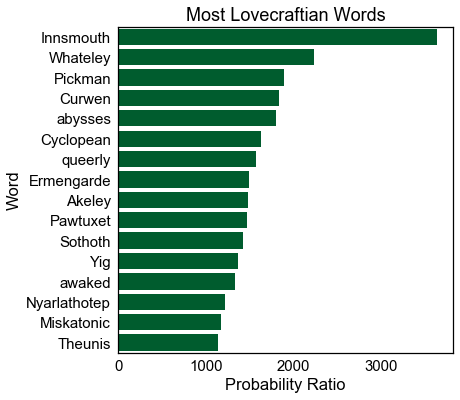

In [14]:
fig = plt.figure(figsize=(6,6), facecolor='w')
p = sns.barplot( x='Prob_ratio', y='Word', data=df.head(16), color=(0,.36,.18),
                 saturation=1)
p.set_xlabel('Probability Ratio')
p.set_title('Most Lovecraftian Words');

We can quickly see that most of the most Lovecraftian words are specific, proper names of people, places, or other named entities (e.g. gods). Even one who is not familiar with Lovecraft's work can see that most of the top words have *capitalized representatives*. Of these top words, 6 are main characters (**Whateley**, **Pickman**, **Curwen**, **Ermengarde**, **Akeley**, and **Theunis**), 3 are towns or institutions (**Innsmouth**, **Pawtuxet**, and **Miskatonic** (University) ), and 3 are gods or monsters ( (Yog)-**Sothoth**, **Yig**, and **Nyarlathotep**). "Innsmouth" stands out as having a *particularly* large probability ratio, due to the number of references to the town in *The Shadow over Innsmouth*.

Of the remaining, we have the uncommonly pluralized noun "**abysses**," as well as "**awaked**," which is an uncommon form of the past-tense verb "awoke" or past participle "awoken." We also have the *very* Lovecraftian adjective "**Cyclopean**," and the similarly Lovecraftian adverb "**queerly**."

---

We might like to remove proper names in order to highlight the other Lovecraftian words. We *could* use elaborate heuristics to detect these proper names. *Instead*, let's simply look at the words that are typically lowercase. We can do this by excluding words whose representative word is capitalized. This will have some false negatives (e.g. words that frequently start sentences), but we'll see that it serves as a decent heuristic:

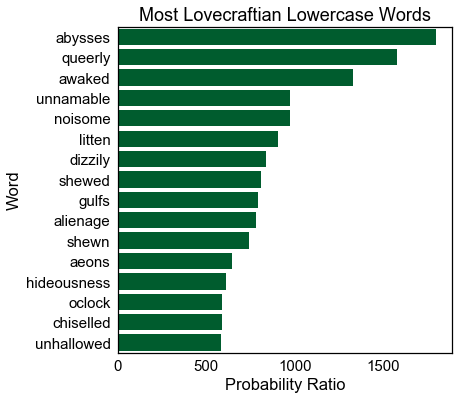

In [25]:
#Only words where 'Word' is lowercase
df_temp = df[ df.Word.str.islower() ].head(16)
fig = plt.figure(figsize=(6,6), facecolor='w')
p = sns.barplot( x='Prob_ratio', y='Word', data=df_temp, color=(0,.36,.18), 
                 saturation=1 )
p.set_xlabel('Probability Ratio')
p.set_title('Most Lovecraftian Lowercase Words');

We can immediately see one arguably false negative: "Cyclopean" was excluded from this list. As a proper adjective &mdash; having been derived from the proper noun "Cyclops" &mdash; it is typically capitalized.

Aside from the other words we saw above, we see more distinctly Lovecraftian adjectives such as "**unnamable**," "**noisome**," and "**dizzily**," as well as the archaic "**litten**" ("lighted") and "**shewed**/**shewn**" ("showed/shown"). We also see a number of Lovecraftian nouns such as "**gulfs**," "**alienage**," "**aeons**," and "**hideousness**."

## Least Lovecraftian Words <a name="4B"></a>

It's also interesting to look at the "least Lovecraftian" words, i.e. the words for which the probability ratio is *smallest*. We'll also filter out words that don't appear in the English word counts (more on these shortly).

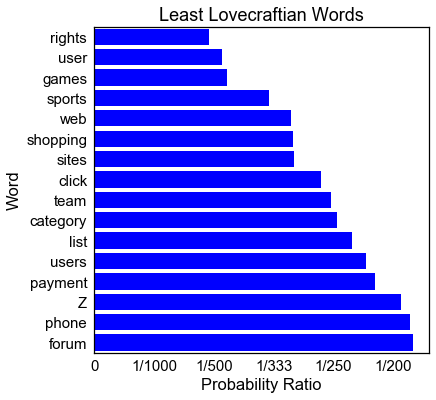

In [26]:
df_temp = df[ df.Count_eng.notna() ].tail(16)[::-1]
fig = plt.figure(figsize=(6,6), facecolor='w')
p = sns.barplot( x='Prob_ratio', y='Word', data=df_temp, color=(0,0,1), 
                 saturation=1 )
p.set_xlabel('Probability Ratio')
p.set_title('Least Lovecraftian Words')

#Show reciprocals of small relative probabilities
xticks = p.get_xticks()
xtick_labels = [ '1/{}'.format( int(1/tick) ) if tick!=0 else '0' 
                for tick in xticks ]
p.set_xticklabels(xtick_labels);

Looking at these words, we can quickly see the bias in our baseline English word counts. The data was clearly collected (at least partially) from websites, so we see a lot of internet-related terminology.

As mentioned above, we could ameliorate this by choosing a more appropriate baseline English corpus or set of word counts. However, I think that this nicely illustrates the bias in the baseline dataset, and that the probability ratios really are capturing the distinct words in *both* datasets, depending on whether the ratio is greater than or less than 1. I'll therefore continue to use these English wordcounts as a baseline.

## Lovecraftian Words Not Present in English Word Counts <a name="4C"></a>

Astute readers will note that &mdash; using our scoring &mdash; the most "Lovecraftian" words could arguably be those that don't appear in the English word counts at all (giving a denominator of 0, and a score that is infinite). This divergence can be partially resolved using clever additive smoothing of the word probabilities, but I found that the best approach is to simply consider these words separately. 

Let's just look at the words that aren't found in our English word counts, sorted by how often they appear in Lovecraft's works.

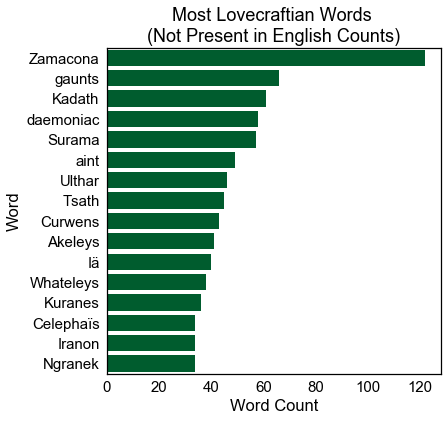

In [27]:
df_temp = df[ df.Count_eng.isna() ].sort_values('Prob_hpl', 
                                                ascending=False).head(16)
plt.figure(figsize=(6,6), facecolor='w')
p = sns.barplot( x='Count_hpl', y='Word', data=df_temp, color=(0,.36,.18),
                 saturation=1 )
p.set_xlabel('Word Count')
p.set_title('Most Lovecraftian Words \n(Not Present in English Counts)');

Again we see a lot of proper names. We see 7 characters (**Zamacona**, **Surama**, **Curwen**(s), **Akeley**(s), **Whateley**(s), **Kuranes**, and **Iranon** ), 1 town (**Ulthar**), and 4 supernatural locations (**Kadath**, **Tsath**, **Celephaïs**, and **Ngranek**). "Zamacona" stands out due to this character being referenced frequently in *The Mound*.

We also see "(night-)**gaunts**" (a race of monsters), "**daemoniac**" (demonic or possessed by a demon), and the informal contraction "**ain't**," which likely appeared in informal dialogue or letters in Lovecraft's stories. 

The word "**Iä**" is often seen in chants to deities such as Cthulhu, which are typically chanted in an alien language:
>Iä! Iä! Cthulhu fhtagn! Ph’nglui mglw’nafh Cthulhu R’lyeh wgah-nagl fhtagn

---

As before, we can also look at only the primarily-lowercase words:

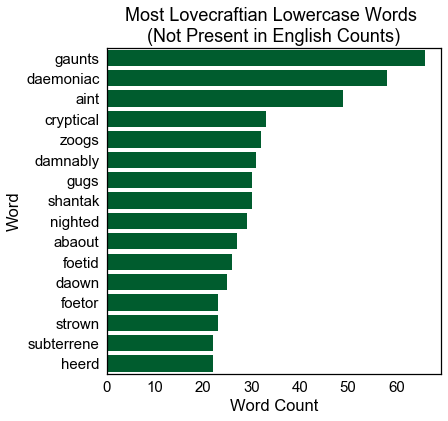

In [28]:
df_temp = df[ df.Count_eng.isna() & df.Word.str.islower() ].sort_values(
                                        'Prob_hpl', ascending=False).head(16)
plt.figure(figsize=(6,6), facecolor='w')
p = sns.barplot( x='Count_hpl', y='Word', data=df_temp, color=(0,.36,.18), 
                 saturation=1 )
p.set_xlabel('Word Count')
title = 'Most Lovecraftian Lowercase Words \n(Not Present in English Counts)'
p.set_title(title);

Here we mostly see more creatures and adjectives, including "**foetid**/**foetor**" (an archaic spelling of "fetid/fetor"). We also see "**abaout**," "**daown**," and "**heerd**," which are words that Lovecraft often uses in dialogue with characters with accents (see also "caows" ("cows"), "ez" ("as"), "shet" ("shut"), etc.).

From *The Shadow Over Innsmouth*:
>Right naow Barnabas is abaout changed. Can’t shet his eyes no more, an’ is all aout o’ shape. They say he still wears clothes, but he’ll take to the water soon.

## Lovecraft "Fan Favorite" Words <a name="4D"></a>

There are a number of words that are commonly considered to be distinctly Lovecraftian, so I wanted to see how these words are actually ranked according to our probability ratios (as well as raw counts). I gathered (by hand) fans' favorite, most Lovecraftian words from a number of H. P. Lovecraft forum threads, as well as how many "votes" each word received. Below is a list of the most highly-rated words, along with their "vote" counts:

- "Cyclopean": 19
- "eldritch": 15
- "gibbous": 11
- "squamous": 10
- "rugose": 8
- "non-Euclidean": 8
- "batrachian": 7
- "gibbering": 6
- "antediluvian": 6
- "foetid": 4
- "betwixt": 4

---

Let's see how these words rank in our dataframe:

Word  Count_hpl  Count_eng  Count_ratio  Prob_hpl  \
5         Cyclopean         76    31556.0     0.002408  0.000108   
138          rugose          6    16848.0     0.000356  0.000008   
261    antediluvian         11    46557.0     0.000236  0.000016   
338         betwixt         42   210303.0     0.000200  0.000059   
385        eldritch         29   158609.0     0.000183  0.000041   
452       gibbering          5    30585.0     0.000163  0.000007   
1340        gibbous          9   125299.0     0.000072  0.000013   
10346      squamous          4   740420.0     0.000005  0.000006   
11620     Euclidean          3   725143.0     0.000004  0.000004   
24418        foetid         26        NaN          NaN  0.000037   
27039    batrachian          1        NaN          NaN  0.000001   

           Prob_eng   Prob_ratio  
5      6.580675e-08  1634.254593  
138    3.513475e-08   241.652318  
261    9.708978e-08   160.322976  
338    4.385650e-07   135.516411  
385    3.307626e-07   124.067560  
452    6.378183e-08   110.930147  
1340   2.612980e-07    48.739714  
10346  1.544069e-06     3.665810  
11620  1.512210e-06     2.807280  
24418           NaN          NaN  
27039           NaN          NaN

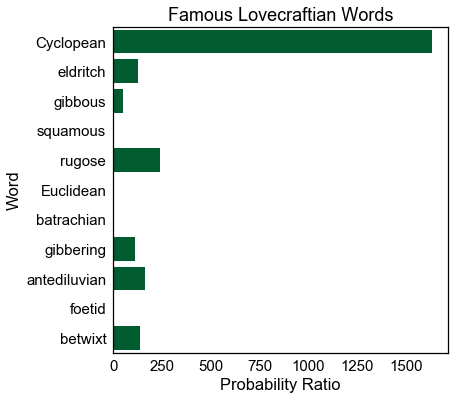

In [29]:
#Used "Euclidean" since tokenizer splits hyphenated words like "non-Euclidean"
popular_words = ['Cyclopean', 'eldritch', 'gibbous', 'squamous', 'rugose', 
                 'Euclidean', 'batrachian', 'gibbering', 'antediluvian', 
                 'foetid', 'betwixt']
df_temp = df[ df.Word.isin(popular_words) ]
plt.figure(figsize=(6,6), facecolor='w')
p = sns.barplot( x='Prob_ratio', y='Word', order=popular_words, data=df_temp, 
                color=(0,.36,.18), saturation=1 )
p.set_xlabel('Probability Ratio')
p.set_title('Famous Lovecraftian Words')
df_temp

"Cyclopean" is as Lovecraftian as expected! Interestingly, none of the others are even in the top 100.

"Eldritch" is actually quite low on the list, probably at least partially due to it being popularized by Lovecraft, thus contributing to the baseline English word counts. For example, he uses the word "phosphorescent" exactly as often as "eldritch," but "eldritch" appears twice as often in English texts as "phosphorescent" does.

Most of these words only appeared a single-digit number of times. A particularly extreme example is "batrachian" (meaning a frog or toad, or froglike or toadlike) which doesn't appear in our English counts, and only appeared *once* in *The Shadow Over Innsmouth*:
> Among these reliefs were fabulous monsters of abhorrent grotesqueness and malignity—half ichthyic and half **batrachian** in suggestion—which one could not dissociate from a certain haunting and uncomfortable sense of pseudo-memory, as if they called up some image from deep cells and tissues whose retentive functions are wholly primal and awesomely ancestral.

It is nonetheless a memorable word among Lovecraft readers, and its popularity may have been amplified by references to the word by Neil Gaiman in his homage to (and parody of) Lovecraft, *Shoggoth's Old Peculiar*. 

## Interactive Word Scatter Plot (Bokeh) <a name="4E"></a>

We can also compare the word counts in our two datasets by plotting our words in two dimensions. Let's make an interactive scatter plot of our words. 

We'll treat the x-axis as representing the frequency of each word in Lovecraft's writings, and the y-axis as representing the frequency of each word in English texts. We'll plot each word as a circle, placed precisely at the appropriate x-y coordinates. We'll also draw tooltips showing what word a circle corresponds to when the user hovers over that circle. Words that are *more Lovecraftian* will be drawn in a **dark teal-green**, and words that are *less Lovecraftian* will be drawn in **primary blue**, with a hard threshold at `Prob_ratio=1` (equally likely in both corpora).

Since the most common words (stop words) have astronomically larger word counts than most words, we'll plot the $\log$ of the word probabilities (giving a log-log scatter plot).

---

We'll build our plot using the [Bokeh](https://bokeh.pydata.org/en/latest/) plotting library. Implementation details can be found in the comments.

In [10]:
#Shuffle points so points are drawn randomly
df_temp = df.sample(frac=1).copy()

#Log transform
df_temp['Log_prob_hpl'] = np.log(df_temp.Prob_hpl)
df_temp['Log_prob_eng'] = np.log(df_temp.Prob_eng)

#Create color coding and embed directly in the dataframe
colors = [(0,0,1),(0,.36,.18)]
def float_to_hex(color):
    r,g,b = color
    return '#{:02x}{:02x}{:02x}'.format( int(r*255), int(g*255), int(b*255) )
color_dict = {False:float_to_hex( colors[0] ), True:float_to_hex( colors[1] ) }
df_temp['Color'] = (df_temp.Prob_ratio>1).map(color_dict)
df_temp.head()

Word  Count_hpl   Count_eng   Count_ratio  Prob_hpl  \
22432      caption          1   4588270.0  2.179471e-07  0.000001   
15001         iron         66  32552371.0  2.027502e-06  0.000093   
2649         lofty         42   1018661.0  4.123060e-05  0.000059   
5663      insanely          7    429321.0  1.630482e-05  0.000010   
27261  sputterings          1         NaN           NaN  0.000001   

           Prob_eng  Prob_ratio  Log_prob_hpl  Log_prob_eng    Color  
22432  9.568359e-06    0.147890    -13.468335    -11.557049  #0000ff  
15001  6.788458e-05    1.375781     -9.278680     -9.597702  #005b2d  
2649   2.124311e-06   27.977421     -9.730665    -13.062063  #005b2d  
5663   8.953043e-07   11.063791    -11.522424    -13.926102  #005b2d  
27261           NaN         NaN    -13.468335           NaN  #0000ff

In [11]:
#Title and labels
title = 'Words from Lovecraft\'s Texts'
xlabel = 'log( Lovecraft Word Probability )'
ylabel = 'log( English Word Probability )'

#Construct figure and plot, set figure extent
p = bkplt.figure( title=title, x_axis_label=xlabel, 
                  y_axis_label=ylabel, plot_width=700, plot_height=700,
                  x_range=(-14, -2), y_range=(-18, -2) )
scatterplot = p.scatter('Log_prob_hpl', 'Log_prob_eng', source=df_temp, size=8, 
                        alpha=0.2, line_alpha=0, color='Color')

#Draw line at x=y
p.line([-14,-2], [-14,-2], line_width=1, line_color='black', line_alpha=0.2)

#Create hover tooltip object that applies to scatter but not line object.
hover = bk.models.HoverTool( tooltips=[('Word', '@Word'),
                                       ('Prob_ratio', '@Prob_ratio')],
                             renderers=[scatterplot] )
p.add_tools(hover)

#Render plot
bkplt.show(p)

By hovering over these points, we can see that the most Lovecraftian words appear on the lower-right, while the least Lovecraftian words appear in the upper left. The most *common* words (stop words) appear on the upper right, and the *least common* on the lower-left. Words that appear equally often in English texts and Lovecraft's writings appear along the $x=y$ line. More generally, words where $x-y=c$ for some constant $c$ are equi-Lovecraftian (😉), having the same probability ratio.

The points are discretized into vertical bands on the left side of the plot, corresponding to words with small-integer word counts (1, 2, 3, etc.). We can also see that the bottom points appear to be cut off, corresponding to the fact that the English word counts are truncated to only include the top 1/3 million words.

## Word Clouds <a name="4F"></a>

Word clouds have a bad reputation among data scientists, *and justifiably so*. They can be very visually messy, and they are nearly useless for drawing precise, quantitative conclusions from a dataset. A word's score is typically represented by font size, which corresponds (approximately) to the word's displayed height. The displayed word's total area, however, will still be roughly proportional to the number of characters in the word. This makes it very difficult to intuitively map a displayed word's size back to its score, or even compare relative scores. By simply using a bar chart (as we did above), we can e.g. quickly see that some word A has roughly twice the score of another word B. This simple task is something that would be difficult if not impossible to accomplish using a word cloud.

Nonetheless, word clouds work well as a fun, "at a glance" rough impression of a bag of words. Word clouds may well be the antithesis of Edward Tufte's principles of data visualization, but their multi-scale nature might arguably still make them amenable to so-called "micro/macro reading." Specifically, the most relevant words draw your eye immediately, and as you take more time to explore the cloud, you make your way progressively into the smaller-scale, less relevant words.

Ultimately, word clouds are still a poor choice if your goal is precise, quantitative visualization.  

So... *let's make some word clouds.*

---

We'll generate our word clouds using the popular [wordcloud](https://github.com/amueller/word_cloud) package, with lots of customization. We'll tame some of the messiness of our clouds by forcing the words to be only plotted horizontally, and we'll further emphasize and outline larger words by fading smaller words into the background. 

This is all accomplished with the following functions:

- `make_fontsize_color_func` creates and returns a function of the type used by the wordcloud package to determine how a given word is colored. Such color functions can take as arguments things like the size or position of a given word, allowing for extensive customization. Here, our function returns a color function that samples a random color from a specified color map, and reduces it's opacity proportional to the word's size (relative to the largest word plotted). This is done via a simple convex combination of the word color and background color.

- Since our color function needs to know the size of the largest word plotted, `find_max_font_size_used` is used to determine this by generating a dummy wordcloud with only a few words, and pulling out the largest font size used.

- `make_wordcloud` uses the previous two functions to generate a wordcloud `WordCloud` object with appropriately-colored words. It also slightly mixes the average word color into the background to roughly simulate the effect of drawing "subpixel"-sized words.

- `plot_wordcloud` plots the generated `WordCloud` object to an axis and removes all unnecessary axis decorations. If a Matplotlib `Axes` object is not specified, it generates one and `show()`s the plot. Otherwise, `show()` can be run manually after all of the word cloud subfigures in a given figure have been generated.

In [32]:
def make_fontsize_color_func(background_color, max_font_size, color_list):
    #Turn color_list into a Matplotlib colormap
    cmap = mpl.colors.LinearSegmentedColormap.from_list('mymap', color_list, 
                                                        N=256, gamma=1.0)
    
    #Construct color function to return
    def color_func(word, font_size, position, orientation, random_state=None,
                  **kwargs):
        #Sample random color from color map
        base_color = cmap( np.random.rand() )[:3]
        
        #Set opacity according to font size and use to mix text color with
        #background.
        opacity = np.sqrt( font_size/max_font_size )
        color = tuple( int(255*( opacity*x+(1-opacity)*y ) ) 
                      for x,y in zip(base_color, background_color) )
        
        return color
    
    return color_func

def find_max_font_size_used(word_scores, font_path=None, max_font_size=None, 
                       width=1024, height=1024):
    #Generate wordcloud with only 10 words
    wordcloud = WordCloud(font_path=font_path, max_font_size=max_font_size,
                          max_words=10, width=width, height=height, 
                          relative_scaling=1, prefer_horizontal=1, 
                          min_font_size=1)
    cloud = wordcloud.generate_from_frequencies(word_scores)
    
    #Pull out the maximum font size used in the word cloud
    max_font_size_used = cloud.layout_[0][1]
    
    return max_font_size_used

def make_wordcloud(word_scores, max_words=100000, font_path=None, 
                   max_font_size=None, background_color=(0,0,0), 
                   color_list=[(1,1,1),(1,1,1)], width=1024, height=1024):
    
    #Calculate largest font size to use in color function
    max_font_size_used = find_max_font_size_used(word_scores=word_scores, 
                                                 font_path=font_path, 
                                                 max_font_size=max_font_size,
                                                 width=width, height=height)
    
    #Create color function
    color_func = make_fontsize_color_func(background_color=background_color, 
                                max_font_size=max_font_size_used,
                                color_list=color_list )
    
    #Mix background color with average text color as an approximation of 
    #subpixel words. Set opacity to that of a word with font size of 0.5.
    min_opacity = np.sqrt( 0.5/max_font_size_used )
    background_color_mixed = ( (1-min_opacity)*np.array(background_color) 
                              + min_opacity*np.mean(color_list, axis=0) )
    
    #Make wordcloud
    wordcloud = WordCloud(font_path=font_path, max_font_size=max_font_size,
                  max_words=max_words, width=width, height=height, 
                  relative_scaling=0.5, 
                  background_color=tuple(int(255*x) 
                                         for x in background_color_mixed),
                  prefer_horizontal=1, min_font_size=1, color_func=color_func)
    cloud = wordcloud.generate_from_frequencies(word_scores)
    
    return cloud

def plot_wordcloud(word_scores, max_words=100000, font_path=None, 
                   max_font_size=None, title='', background_color=(0,0,0), 
                   color_list=[(1,1,1),(1,1,1)], width=1024, height=1024,
                   border_width=1, ax=None):
    
    #Flag to determine whether or not plt.show() is executed at the end
    show_plot = False
    
    #If no axes specified, generate new axes and run plt.show() at the end 
    if ax==None:
        ax = plt.gca()
        show_plot = True
    
    #Create wordcloud
    cloud = make_wordcloud(word_scores=word_scores, max_words=max_words, 
                           font_path=font_path, max_font_size=max_font_size,
                           background_color=background_color, 
                           color_list=color_list, width=width, height=height)
    
    #Plot wordcloud
    ax.imshow(cloud, interpolation='bilinear', aspect='auto')

    #Remove all axis decorations, set title
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)
    
    #Create border colored as average text color
    mean_color = np.mean(color_list, axis=0)
    mean_color = (mean_color+background_color)/2
    for spine in ax.spines.values():
        spine.set_color(mean_color)
        spine.set_linewidth(border_width)

    #Show plot (if no axes specified above)
    if show_plot==True:
        plt.show()
    
    return ax

Let's apply our new function to our most Lovecraftian words:

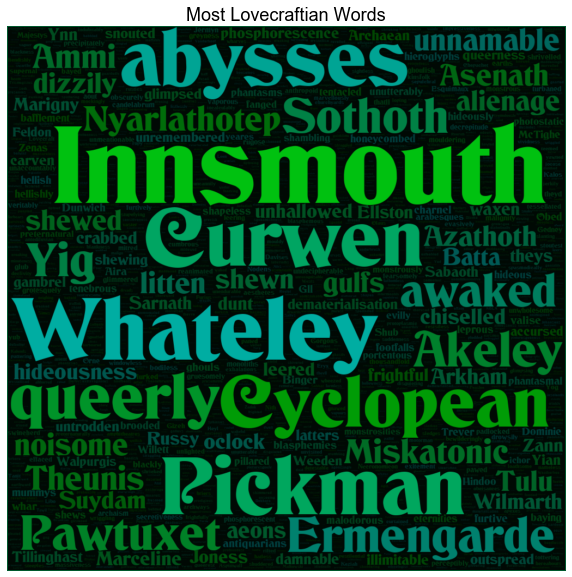

In [30]:
plt.figure(figsize=[10,10], facecolor='w')
word_scores = dict( zip(df.Word, df.Prob_ratio) )
font_path = './fonts/columbus.ttf'
color_list = [(0,.7,0), (0,.7,.7)]
title = 'Most Lovecraftian Words'
plot_wordcloud(word_scores, font_path=font_path, title=title, 
               color_list=color_list );

Now let's try it on our most Lovecraftian *lowercase* words:

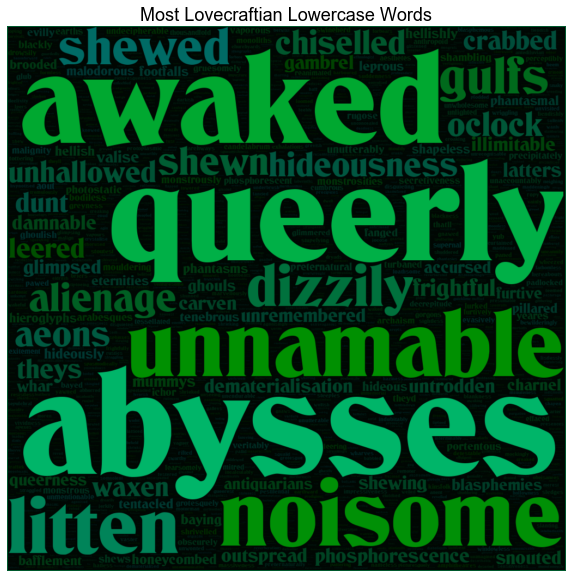

In [33]:
df_temp = df[df.Word.str.islower()]
plt.figure(figsize=[10,10], facecolor='w')
word_scores = dict( zip(df_temp.Word, df_temp.Prob_ratio) )
font_path = './fonts/columbus.ttf'
color_list = [(0,.7,0), (0,.7,.7)]
title = 'Most Lovecraftian Lowercase Words'
plot_wordcloud(word_scores, font_path=font_path, title=title, 
               color_list=color_list );

Finally, let's have a look at the *least* Lovecraftian words (*internet terminology*):

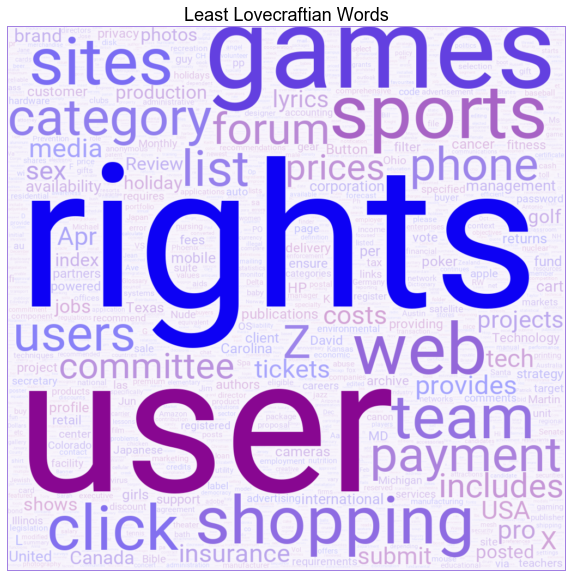

In [34]:
plt.figure(figsize=[10,10], facecolor='w')
word_scores = dict( zip(df.Word, 1/df.Prob_ratio) )
font_path = './fonts/Roboto.ttf'
color_list = [(0,0,1), (.54,0,.54)]
background_color = (1,1,1)
title = 'Least Lovecraftian Words'
plot_wordcloud(word_scores, font_path=font_path, title=title, 
               color_list=color_list, background_color=background_color );


---

Now that we've gotten those messy word clouds out of our system, let's move on to *topic modeling*!

# Topic Modeling (Latent Dirichlet Allocation) <a name="5"></a>

Topic modeling is a statistical method for automatically extracting different "topics" from a set of text documents. These "topics" could be topics in the literal sense, but may also simply be "contexts," styles of speaking, or even different languages. We'll see if we can apply these methods to our corpus to extract a good set of distinct topics commonly used by Lovecraft.

To model the topics in our corpus, we'll be using "[latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)" (LDA). LDA treats each topic as a distribution of individual words, and treats each *document* as a distribution of *topics*. Specifically, it assumes that both the per-document topics and per-topic words have ([conjugate](https://en.wikipedia.org/wiki/Conjugate_prior)) [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) [prior](https://en.wikipedia.org/wiki/Prior_probability) distributions (with vector parameters $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$, respectively). It then finds the appropriate posterior topic and word distributions given a corpus of documents. In practice, the posterior is approximated using a [variational Bayesian method](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), since the true posterior is intractable. The number of topics is not learned from the data, and must be determined by other means. There exist methods (see e.g. [hierarchical Dirichlet process](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process)) that can also learn the number of topics, but that is beyond the scope of this project.

There are a number of good Python implementations of LDA, such as the one found in the popular [gensim](https://radimrehurek.com/gensim/) topic modeling package. We'll be using [scikit-learn](http://scikit-learn.org/stable/index.html)'s implementation, [`LatentDirichletAllocation`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

Note that, as above, we will *not* be removing stop words, despite this being standard practice in topic modeling. Instead, we will again normalize our words in a way that naturally deals with stop words *after finding our topics*. For a similar approach and justification I encourage you to have a look at [this paper](http://www.cs.cornell.edu/~xanda/stopwords2017.pdf) on omitting stopword removal in topic modeling.

## Documents (Paragraphs) <a name="5A"></a>

To apply LDA, we need a set of "documents." We could, of course, treat each Lovecraft story as a document. Having experimented with treating stories, paragraphs, and even individual sentences as documents, I've found that paragraphs give a nice tradeoff between number and length of documents (6164 paragraphs versus 101 stories). This also allows for the LDA to pick up "topics" that change from paragraph to paragraph, e.g. introductions, locale descriptions, conversations, etc. [This article](https://tedunderwood.com/2012/04/01/what-kinds-of-topics-does-topic-modeling-actually-produce/) provides a nice discussion of the effect of document granularity on topic modeling.

Let's define a function `split_paragraphs` that splits a string into paragraphs, and a function `load_texts_paragraphs` that loads a set of text files, splits them into paragraphs using `split_paragraphs`, and returns a list of paragraphs:

In [15]:
def split_paragraphs(text):
    #Simple heuristic: Split everywhere a newline is bookended 
    #by at least one space or newline.
    regex = re.compile(r'[ \n]+\n[ \n]+')
    paragraphs = regex.split(text)
    return paragraphs

def load_texts_paragraphs(filenames):
    paragraphs_list = []
    for filename in filenames:
        text = load_text(filename)
        paragraphs_list.extend( split_paragraphs(text) )
    return paragraphs_list

Let's go ahead and apply it to our corpus:

In [16]:
filenames = glob.glob('./data/stories/*.txt')
docs = load_texts_paragraphs(filenames)

print( '{} documents total.'.format( len(docs) ) )

6164 documents total.


## LDA Topic-Word and Document-Topic Posterior Distributions <a name="5B"></a>

Now, let's define a function &mdash; `fit_lda` &mdash; that will perform LDA on our paragraphs list.

`LatentDirichletAllocation`'s `.fit` method requires that our data be transformed into a "document-word matrix," which is essentially an economical representation of the word counts in each document. Fortunately, scikit-learn's `CountVectorizer` can perform this transformation for us. We'll have it omit words that appear only once from our counts.

Our document-word matrix represents each word as an integer index. Later, we'll want to reference back to the original strings that these indices correspond to. To do this, we'll save these strings in a list (`words`).

We'll then apply LDA to our word counts. See the code and comments below for specific parameter settings. Note that one could adjust the $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$ parameters here to change the corresponding Dirichlet priors, but we'll stick with the defaults here. If you *do* want to tweak these parameters, note that in scikit-learn `doc_topic_prior` is $\boldsymbol{\alpha}$ and `topic_word_prior` is $\boldsymbol{\beta}$.

After fitting our LDA, we save our posterior per-topic word distribution as `topic_word_distr`, and our posterior per-document topic distribution as `doc_topic_distr`. We then sort these distributions by topic frequency, thus implicitly sorting our topics by how frequently they occur in the corpus.

Finally, the function returns our two posterior distributions, as well as our list of words.

In [17]:
def fit_lda(docs, n_topics, max_iter=1000, random_state=55):
    #Using tokenize_text function defined in previous section
    #Only include words that were seen at least twice
    count_vectorizer = CountVectorizer(tokenizer=tokenize_text, min_df=2)
    
    #Document word matrix
    counts = count_vectorizer.fit_transform(docs)
    
    #Get words corresponding to indices of document word matrix above,
    #convert these to their representative words using token_to_repr
    words = count_vectorizer.get_feature_names()
    words = np.array( [ token_to_repr[word] for word in words ] )

    #Runs until perplexity tolerance is reached (or max_iter iterations).
    #Tests perplexity every 10 iterations to detect convergence.
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter, 
                                    evaluate_every=10, learning_method='batch', 
                                    random_state=random_state, 
                                    n_jobs=-1).fit(counts)
    
    #Display total number of iterations taken to converge
    print( 'Perplexity converged after {} iterations.'.format(lda.n_iter_) )
     
    
    #Get distribution of words for each topic
    topic_word_distr = lda.components_
    
    #Get distribution of topics for each document
    doc_topic_distr = lda.transform(counts)
    
    #Calculate overall distribution of topics, get indices of topics sorted by
    #topic count (descending)
    topic_distr = doc_topic_distr.sum(axis=0)
    topic_ix_sorted = topic_distr.argsort()[::-1]

    #Sort distributions by topic count
    topic_word_distr = topic_word_distr[topic_ix_sorted]
    doc_topic_distr = doc_topic_distr[:, topic_ix_sorted]
    
    return topic_word_distr, words, doc_topic_distr

Next, we'll apply our new function to our list of paragraphs. 

As discussed above, the number of topics is a parameter that we must either select ourselves, or via some other automated process. While we could in principle determine an "optimal" number of topics using cross-validation or some form of heuristic, this may very well give us hundreds (or even thousands) of topics to deal with! Since we ultimately want to explore and visualize our topics, we'll just select a number of topics that seems reasonably large, while still being tractable.

Let's work with 20 topics for now:

In [17]:
n_topics = 20
topic_word_distr, words, doc_topic_distr = fit_lda(docs, n_topics)

Perplexity converged after 129 iterations.


Nice!

### Save LDA Results to Disk

Since LDA can sometimes take a while to converge, let's save our arrays to disk using `np.save()`. Note that any *list* we save this way will be converted to NumPy array, but this is fine for our purposes.

In [18]:
#Save docs and outputs of fit_lda to single compressed file
np.savez_compressed('./saved/lda_results.npz', 
                    docs=docs, 
                    topic_word_distr=topic_word_distr, 
                    words=words,
                    doc_topic_distr=doc_topic_distr)

### Reload Pre-Calculated LDA Results from Disk

Now, if we want to skip the above training procedure, we can simply skip to here and load our LDA results from disk:

In [21]:
#Load arrays from file
with np.load('./saved/lda_results.npz') as lda_results:
    docs = lda_results['docs']
    topic_word_distr = lda_results['topic_word_distr']
    words = lda_results['words']
    doc_topic_distr = lda_results['doc_topic_distr']

## Topic Bar Plots <a name="5C"></a>

To visualize our extracted topics, let's make a function &mdash; `plot_topics` &mdash; that shows the top words for each topic as a *bar plot*.

This function creates a grid of per-topic subplots. For each subplot, it displays the topic's frequency (derived from `doc_topic_distr`) in the corpus as a percentage. It also displays the "top" words for each topic (determined by `topic_word_distr_sort`), and display's words' "scores" (determined by `topic_word_distr_bar`) as horizontal bars. We could have used a single topic-word distribution for both sorting and plotting the bars, but we'll soon see why having two separate distributions is useful.

See comments and code below for implementation details:

In [85]:
def plot_topics( doc_topic_distr, topic_word_distr_sort, topic_word_distr_bar, 
                 words, rows, cols, figsize=(11,11), max_words=10, title='',
                 color=(0,0,0) ):
    #Create figure and subfigure axes
    fig, axs = plt.subplots(rows, cols, figsize=figsize, facecolor='w')
    
    #Calculate overall distribution of topics, then normalize it.
    topic_distr = doc_topic_distr.sum(axis=0)
    topic_distr_norm = topic_distr/topic_distr.sum()
 
    #For each subfigure
    for i,ax in enumerate( axs.ravel() ):

        #Remove xticklabels and spines on all axes (including empty subfigures)
        ax.set_xticklabels([])
        for spine in ax.spines.values():
            spine.set_visible(False)

        #Load word distributions for current topic. If out of range, subfigure
        #is empty, so remove yticklabels.
        try:
            word_distr_sort = topic_word_distr_sort[i]
            word_distr_bar = topic_word_distr_bar[i]
        except IndexError:
            ax.set_yticklabels( [] )
            continue

        #Sort words by score, and reverse their order (highest score first)
        word_ix_sorted = word_distr_sort.argsort()[::-1]
        top_word_distr = word_distr_bar[word_ix_sorted][:max_words]
        top_words = words[word_ix_sorted][:max_words]
        
        #Generate bar plot
        p = sns.barplot(top_word_distr, top_words, linewidth=0, color=color, 
                        saturation=1, ax=ax)

        #Set title, including topic number and topic prevalence
        p.set_title('Topic {}: {:.1f}%'.format(i, topic_distr_norm[i]*100), x=0)

    #Set overall figure plot and layout
    fig.suptitle(title, y=1.03, fontsize=24)
    fig.tight_layout(h_pad=2)

    return

First, let's go ahead and apply our new function to our posterior distributions. We'll use `topic_word_distr` to both sort the per-topic words, and to draw their corresponding bars:

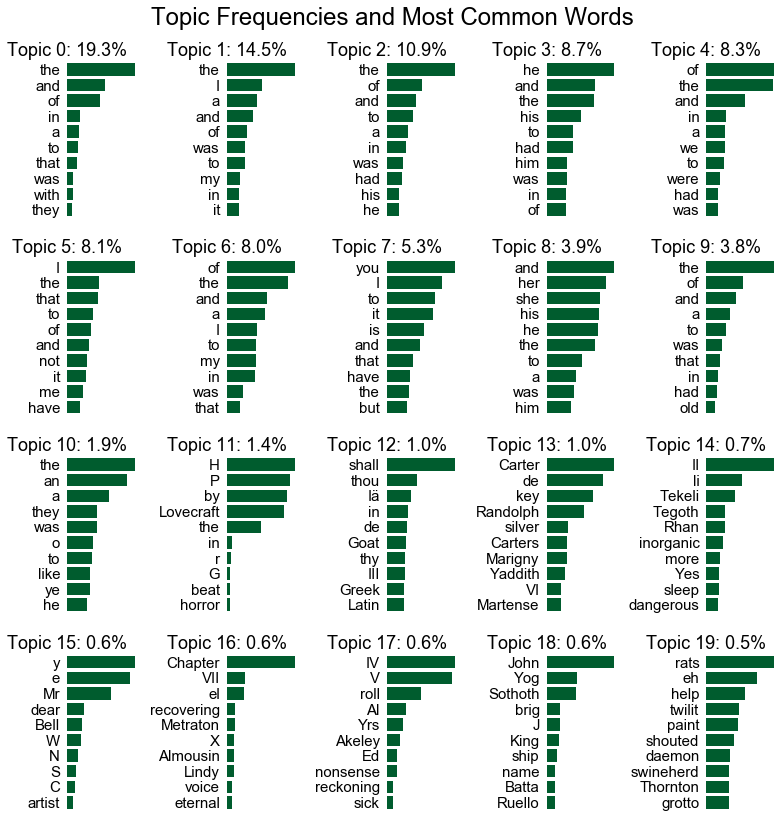

In [86]:
title = 'Topic Frequencies and Most Common Words'
plot_topics( doc_topic_distr, topic_word_distr, topic_word_distr, words, 
             rows=4, cols=5, title=title, color=(0,.36,.18) )

We can immediately see why it's standard to remove stop words before applying LDA: Many of the topics' (the most *common* topics) top words are stop words, which tells us very little about those topics. We *could* remove these stop words *after* applying LDA, and the [paper mentioned above](http://www.cs.cornell.edu/~xanda/stopwords2017.pdf) argues that this is as effective as removing them *prior* to applying LDA. In the following section, we'll take a different approach that doesn't involve removing stop words at all.

Before we do that, note that we can see some patterns even in the topics that are dominated by stop words. For example, topic 3 favors masculine pronouns, whereas topic 8 favors feminine pronouns. This suggests passages that discuss a man or a woman, respectively. Topics like topic 7 favor first and second-person pronouns ("**you**" and "**I**") suggesting a possible dialogue between characters. These patterns would be harder to detect if we had removed all stop words, which almost always includes such pronouns. Let's proceed with our alternate approach.

## Per-Topic Word Probability Ratios <a name="5D"></a>

Earlier in this project, we found the most Lovecraftian words by constructing *probability ratios* for each word. There, we compared each word's frequency in the corpus to its overall frequency in English, thus treating our English word counts as a *baseline*. Here, we'll take a similar approach in order to pick out the words that are most *distinct* to each topic.

To this end, we'll estimate each topic's word probabilities ($P(\text{word}\mid \text{topic}=k)$) by simply normalizing each row of our per-topic word distribution (`topic_word_distr`). We'll also calculate the total word probabilities *over all topics* ($P(\text{word})$) by summing up all of the rows in our per-topic word distribution and normalizing that. Note that this second distribution is simply the word distribution for our *entire Lovecraft corpus* (with some [additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) due to the Dirichlet prior).

We'll then use these probabilities to calculate our per-topic probability ratios:
$$\text{PRatio}(\text{word}, k) = \frac{P(\text{word}\mid \text{topic}=k)}{P(\text{word})}.$$

Thus, we obtain scores that tell us how much more likely a word is to appear in a *specific topic*, compared to the entire corpus.

All of the above steps are wrapped up into the function `rescale_topics` below:

In [87]:
def rescale_topics(topic_word_distr):
    #Normalize each per-topic word distribution
    topic_word_distr_sums = topic_word_distr.sum(axis=1)[:, np.newaxis]
    topic_word_distr_norm = topic_word_distr/topic_word_distr_sums
    
    #Build *overall* word distribution: Sum over all rows, normalize result.
    #Would get identical result by normalizing by raw word counts and
    #using additive smoothing to match the Dirichlet prior pseudocounts.
    word_distr = topic_word_distr.sum(axis=0)
    word_distr_norm = word_distr/word_distr.sum()
    
    #Divide each per-topic word distribution by the total word distribution.
    topic_word_distr_rel = topic_word_distr_norm/word_distr_norm
    
    return topic_word_distr_rel

Let's apply this function to our per-topic word distribution to obtain per-topic word probability ratios.

In [88]:
topic_word_distr_rel = rescale_topics(topic_word_distr)

Now we can use our new probability ratios in our `plot_topics` function. Specifically, we'll use these probability ratios to determine the the top words for each topic (and their order), but we'll use our *original* per-topic word distribution to draw the bars. The latter choice is due to the fact that the top words for a topic (by probability ratio) tend to have very similar probability ratios, and thus nearly-identical bars. We'll see that this hybrid of scaled and unscaled distributions can be very informative. 

Let's have another look at our topics!

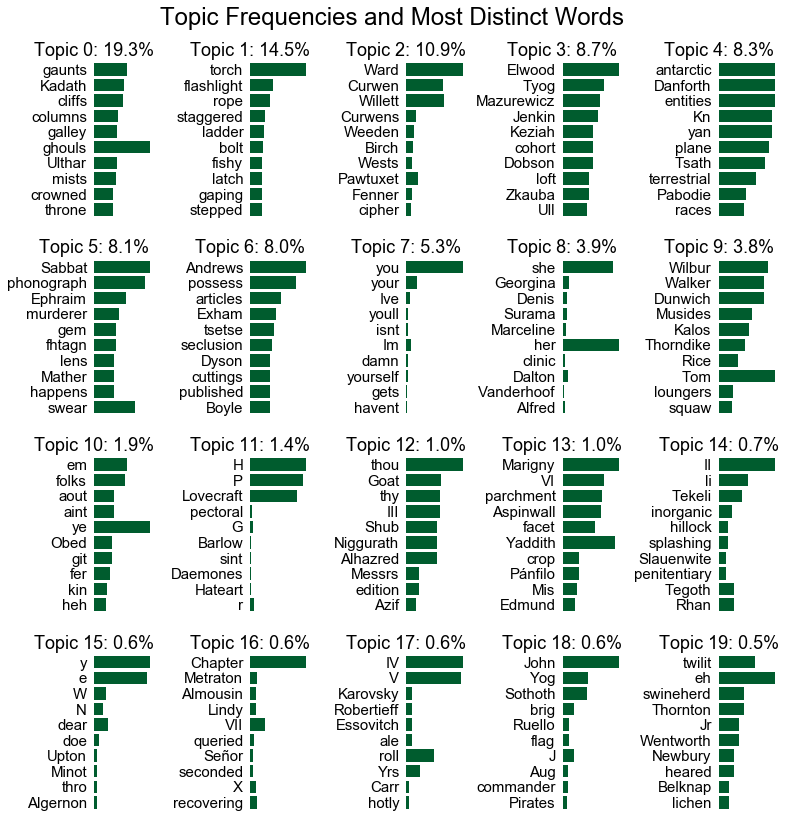

In [89]:
title = 'Topic Frequencies and Most Distinct Words'
plot_topics( doc_topic_distr, topic_word_distr_rel, topic_word_distr, words, 
             rows=4, cols=5, title=title, color=(0,.36,.18) )

Now we can see some nice clustering of related (co-occurring) words! Let's attempt to interpret these topics.

## Topics Interpretation <a name="5E"></a>

### Display Documents Most Strongly Associated with a Topic

To further assist us in interpreting these topics, we can use the document-topic distribution that we obtained from LDA to view the paragraphs that assign the highest probability to a given topic. Let's quickly make a new function that does so. 

`display_top_topic_documents` starts by accessing the column of `doc_topic_distr` corresponding to the topic of interest. It then sorts the column by the per-document topic count and uses those indices to display the top documents in `docs`. `max_docs` determines the number of top documents to display.

In [21]:
def display_top_topic_documents(topic_index, doc_topic_distr, docs, max_docs=1):
    #Access topic column, argsort to obtain document indices sorted by topic 
    #count. Reverse for descending order. 
    doc_indices = doc_topic_distr[:, topic_index].argsort()[::-1]
    
    for i in range(max_docs):
        #Use doc_indices to index into docs. Replace newlines with spaces.
        doc_str = docs[ doc_indices[i] ].replace('\n', ' ')
        header ='*Topic {}.* **Document rank: {}.**\n>'.format(topic_index,i+1) 
        display( Markdown(header + doc_str) )

    return

Now we're ready to dive into our topics!

### Topic: Spelunking

Let's start with a topic that seems to capture what looks like a true "topic" in the traditional sense. **Topic 1** is one of the most common topics in our Lovecraft corpus, present in around 15% of our documents. It consists of tools that might be used when exploring caves or other darkened corridors and vertical passages (**torch**, **flashlight**, **rope**, **ladder**, **bolt**, **latch**), as well as verbs and adjectives that one might use when describing such exploration ("**staggered**," "**stepped**," and "**gaping**"). We therefore might call this topic "spelunking."

Let's use our new `display_top_topic_documents` function to see the paragraph most strongly associated with this topic:

In [22]:
display_top_topic_documents(1, doc_topic_distr, docs, max_docs=1)

*Topic 1.* **Document rank: 1.**
>Everything else on the mound was as I had left it—brush cut by my machete, slight, bowl-like depression toward the north end, and the hole I had made with my trench-knife in digging up the magnetism-revealed cylinder. Deeming it too great a concession to the unknown jokers to return to Binger for another pick and shovel, I resolved to carry out my programme as best I could with the machete and trench-knife in my handbag; so extracting these, I set to work excavating the bowl-like depression which my eye had picked as the possible site of a former entrance to the mound. As I proceeded, I felt again the suggestion of a sudden wind blowing against me which I had noticed the day before—a suggestion which seemed stronger, and still more reminiscent of unseen, formless, opposing hands laid on my wrists, as I cut deeper and deeper through the root-tangled red soil and reached the exotic black loam beneath. The talisman around my neck appeared to twitch oddly in the breeze—not in any one direction, as when attracted by the buried cylinder, but vaguely and diffusely, in a manner wholly unaccountable.

This paragraph from *The Mound* seems to confirm our interpretation. 

Note that running LDA with different random seeds or number of topics leads to other, similar topics that capture descriptions of specific environments.

### Topics: Stories

Many topics extracted by LDA might not be considered "topics" in the traditional sense. For example, 6 of the 20 topics seem to primarily capture individual *stories*. This might not be remarkable had we treated each story as a document, but LDA has managed to detect different stories by looking at individual *paragraphs*. 

- **Topic 0** clearly corresponds to *The Dream Quest of Unknown Kadath*, which features (night)-**gaunts**, **ghouls**, and the locations **Kadath** and **Ulthar**. This is also the most *common* topic, likely due to this being one of Lovecraft's longest stories. 
- **Topic 2** corresponds to *The Case of Charles Dexter Ward,* as most of its distinct words are characters from that story (Charles Dexter **Ward**, Joseph **Curwen**, Marinus Bicknell **Willett**, Ezra **Weeden**, etc.). 
- **Topic 4** corresponds to *At the Mountains of Madness*, a story about an **Antarctic** expedition by characters including **Danforth** and Frank **Pabodie**, with frequent reference to **planes** and (extra-)**terrestrials**. We also see the locations **K'n-yan** and **Tsath** from *The Mound* &mdash; another story that similarly explores an alien culture. 
- **Topic 13** corresponds to *Through the Gates of the Silver Key*, which features characters Étienne-Laurent de **Marigny** and Ernest B. **Aspinwall**, the planet **Yaddith**, and an ancient, cryptic **parchment**. 
- **Topic 19** corresponds to *The Rats in the Walls*, which includes character **Thornton**, frequent references to a **swineherd**, and repeated use of the adjective "**twilit**."
- **Topic 3** seems to largely center around *The Dreams in the Witch House*, which has characters Frank **Elwood**, Joe **Mazurewicz**, **Keziah** Mason and the rat-like creature, "Brown **Jenkin**." 

### Topics: Gender and Point of View

The remaining names in topic 3 are from other stories, but all are male, which may explain the focus on masculine pronouns in our previous word distribution for this topic. 

In contrast, **topic 8** emphasizes *female characters* (**Georgina** Clarendon from *The Last Test* and **Marceline** Bedard from *Medusa's Coil*) which are (unfortunately) rare in Lovecraft's stories. We also see prominent *feminine pronouns*, which are particularly remarkable given that we are now *penalizing* such common English stop words. This all reinforces our hypothesis that topic 8 captures passages that involve female characters. Similarly, we again see that **topic 7** emphasizes *first-person* and *second-person pronouns*, as well as *contractions* and other *informal language*. This suggests that topic 7 captures informal dialogue and letters directly addressing someone, as opposed to e.g. narration. **Again we see the utility of stop words in topic modeling.**

Let's see the top paragraphs for topic 8:

In [30]:
display_top_topic_documents(8, doc_topic_distr, docs, max_docs=4)

*Topic 8.* **Document rank: 1.**
>Calvin edges close to the traveller and sometimes seizes a coat-lapel with his gnarled, mottled hand while he half shuts his watery blue eyes.

*Topic 8.* **Document rank: 2.**
>In the pale dawn, James spoke softly to Georgina, who could do no more than put her head on his breast and sob.

*Topic 8.* **Document rank: 3.**
>As Rogers glanced toward the padlocked inner door Jones retrieved his hat and stick from a nearby bench.

*Topic 8.* **Document rank: 4.**
>Dr. Clarendon shewed no surprise, but kept on at the writing before him.

Aside from the rank-2 paragraph, we don't see as many female characters as we might expect. This is partly due to what might be considered a flaw in the way we choose our representative documents for a given topic. Specifically, our method will tend to favor *short* paragraphs containing words that are *unique* to that topic, as the unique words are less "diluted" by words shared with other topics. This is reasonable, but may lead to very noisy results. We *could* ameliorate this by simply omitting shorter paragraphs in our ranking. Instead, let's weight our documents by their length, so as to penalize for very short paragraphs. 

We can do this by gathering the document lengths in an array and multiplying our document-topic distribution by this array. We then simply apply `display_top_topic_documents` to our weighted document-topic distribution.

In [32]:
doc_lengths = np.array( [ len(doc) for doc in docs ] )
#Add newaxis so dimensions match
doc_topic_distr_weighted = doc_topic_distr*doc_lengths[:,np.newaxis]

display_top_topic_documents(8, doc_topic_distr_weighted, docs, max_docs=2)

*Topic 8.* **Document rank: 1.**
>His voice trailed off in a mumble, and he fell into a stupor. Dalton rang the bell, but Margarita had gone to bed, so he called up the stairs for Georgina. She was firm of step, but very pale. Alfred’s scream had tried her sorely, but she had trusted James. She trusted him still as he shewed her the unconscious form on the lounge and asked her to go back to her room and rest, no matter what sounds she might hear. He did not wish her to witness the awful spectacle of delirium certain to come, but bade her kiss her brother a final farewell as he lay there calm and still, very like the delicate boy he had once been. So she left him—the strange, moonstruck, star-reading genius she had mothered so long—and the picture she carried away was a very merciful one.

*Topic 8.* **Document rank: 2.**
>During our sunset dash through Portland the muttering commenced again, more distinctly than before, and as I listened I caught a stream of utterly insane drivel about Asenath. The extent to which she had preyed on Edward’s nerves was plain, for he had woven a whole set of hallucinations around her. His present predicament, he mumbled furtively, was only one of a long series. She was getting hold of him, and he knew that some day she would never let go. Even now she probably let him go only when she had to, because she couldn’t hold on long at a time. She constantly took his body and went to nameless places for nameless rites, leaving him in her body and locking him upstairs—but sometimes she couldn’t hold on, and he would find himself suddenly in his own body again in some far-off, horrible, and perhaps unknown place. Sometimes she’d get hold of him again and sometimes she couldn’t. Often he was left stranded somewhere as I had found him . . . time and again he had to find his way home from frightful distances, getting somebody to drive the car after he found it.

Excellent! Now we can clearly see paragraphs that are centered around or discuss female characters. 

---

Let's see the top paragraphs for topic 7. We'll stick with our original, unweighted document-topic distribution from now on: 

In [37]:
display_top_topic_documents(7, doc_topic_distr, docs, max_docs=3)

*Topic 7.* **Document rank: 1.**
>“Well, this is bigger still. I never told you about this, because I wanted to work out the later parts before making any claim. When you see the snapshots you’ll know the geography couldn’t have been faked, and I fancy I have another way of proving that  It  isn’t any waxed concoction of mine. You’ve never seen it, for the experiments wouldn’t let me keep It on exhibition.”

*Topic 7.* **Document rank: 2.**
>“See here, Rogers, this won’t do. There are limits, you know. It’s a great piece of work, and all that, but it isn’t good for you. Better not see it any more—let Orabona break it up, and try to forget about it. And let me tear this beastly picture up, too.”

*Topic 7.* **Document rank: 3.**
>“You’ve laughed enough at my work—now it’s time for you to get some facts. Orabona tells me you heard a dog screaming around here this afternoon.   Do you know what that meant?”

As expected, topic 7 favors informal dialogue with one character directly addressing another.

### Topics: Accented, Archaic, and Alien Speech

A number of our topics clearly capture different languages or ways of speaking.

**Topic 10** captures dialogue with a strong perhaps slurred accent, with phonetic spellings of words such as "**aout**," "**git**," and "**fer**." While this sort of speech appears in a number of Lovecraft's stories, the presence of the name "**Obed**" suggests that our model is specifically capturing dialogue with *The Shadow over Innsmouth* character "Zadok Allen" &mdash; the "half-crazed, liquorish nonagenarian whose tales of old Innsmouth and its shadow were so hideous and incredible." This topic's word distribution matches up very well with his slurred language and discussion of the aforementioned character "Obed Marsh."

The top document for this topic shows a typical quote from Zadok:

In [36]:
display_top_topic_documents(10, doc_topic_distr, docs, max_docs=1)

*Topic 10.* **Document rank: 1.**
>“Heh, heh, heh, heh! Beginnin’ to see, hey? Mebbe ye’d like to a ben me in them days, when I seed things at night aout to sea from the cupalo top o’ my haouse. Oh, I kin tell ye, little pitchers hev big ears, an’ I wa’n’t missin’ nothin’ o’ what was gossiped abaout Cap’n Obed an’ the folks aout to the reef! Heh, heh, heh! Haow abaout the night I took my pa’s ship’s glass up to the cupalo an’ seed the reef a-bristlin’ thick with shapes that dove off quick soon’s the moon riz? Obed an’ the folks was in a dory, but them shapes dove off the far side into the deep water an’ never come up. . . . Haow’d ye like to be a little shaver alone up in a cupalo a-watchin’ shapes  as wa’n’t human shapes?  . . . Hey? . . . Heh, heh, heh, heh. . . .”

---

In **Topic 12** we see the archaic pronoun "**thou**," and its possessive, "**thy**," indicating archaic speech. We also see "**Goat**," "**Shub**," and "**Niggurath**," which is capturing the frequently-seen phrase "The Black Goat of the Woods with a Thousand Young," that often accompanies mentions of the god [Shub Niggurath](https://en.wikipedia.org/wiki/Shub-Niggurath).

**Topic 14** seems to be primarily capturing the similarly-specific "**Tekeli**-**li**! **Tekeli**-**li**!" which is frequently uttered by the [shoggoths](https://en.wikipedia.org/wiki/Shoggoth) in *At the Mountains of Madness*. The top document for this topic confirms this:

In [27]:
display_top_topic_documents(14, doc_topic_distr, docs, max_docs=1)

*Topic 14.* **Document rank: 1.**
>“Tekeli-li! Tekeli-li!”  

Note that when run with different random seeds, LDA also tended to pick up passages that included Spanish.

### Topics: Story Titles and Chapters

**Topic 11** favors "**H**," "**P**," and "**Lovecraft**," suggesting that it's capturing *titles of stories* (which always end in "by H. P. Lovecraft"). Similarly, **topic 16** is mostly detecting the word "**Chapter**," which suggests that it is capturing *chapter headings*.

The top documents for these topics confirm both of these interpretations:

In [38]:
display_top_topic_documents(11, doc_topic_distr, docs, max_docs=3)

*Topic 11.* **Document rank: 1.**
>"The Horror in the Burying-Ground" by H. P. Lovecraft

*Topic 11.* **Document rank: 2.**
>"Pickman's Model" by H. P. Lovecraft

*Topic 11.* **Document rank: 3.**
>"The Unnamable" by H. P. Lovecraft

In [41]:
display_top_topic_documents(16, doc_topic_distr, docs, max_docs=3)

*Topic 16.* **Document rank: 1.**
>Clarendon’s eyes flashed dangerously.

*Topic 16.* **Document rank: 2.**
>Chapter VII

*Topic 16.* **Document rank: 3.**
>Chapter X

---

Thus we see how LDA is very capable of extracting "topics" from our corpus, though not always in the *traditional* sense of the word. These topics are often challenging to interpret, but by rescaling our per-topic word distributions and inspecting top documents for each topic, we've managed to make decent sense of what are ultimately just clusters of co-occurring words.

---

Now, let's move on to the final stage of our project &mdash; *language modeling*.

# Character-Based Markov Language Model and Text Generator <a name="6"></a>

To finish things up, let's construct a [language model](https://en.wikipedia.org/wiki/Language_model) that will generate novel text that mimics our corpus, one letter at a time. Specifically, let's construct a (character-based) [*Markov chain*](https://en.wikipedia.org/wiki/Markov_chain). A Markov chain models one-dimensional arrays of data (such as text, time series, or DNA) by assuming that the current symbol only depends on the previous $k$ symbols (the length-$k$ "history"). This allows us to completely define the current symbol's behavior by a conditional probability of the form
$$P( X_t \mid X_{t-1}, X_{t-2}, \cdots, X_{t-k} ).$$

We refer to $k$ as the *order* of the Markov chain. Note that "Markov chain" also often refers specifically to *order-1* Markov chains (the current symbol only depends upon the previous symbol), but we will be using the more general definition.

Our character-based Markov chain's conditional probabilities can be estimated directly from our corpus by simply counting the number of times each character follows a length-$k$ history of characters. If we normalize each of these character counts by the total character count (per history), we obtain a reasonable estimate of the conditional character probabilities.

---

This direct approach of collecting counts and dividing by total counts is arguably a crude method for estimating our probabilities. This [*maximum likelihood estimate*](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) will, for example, assign zero probability to characters that haven't been seen to follow a given history. This might be justified if we have enough data, but we might otherwise like to assign a small but finite probability to characters that we simply haven't seen *yet*. A simple improvement to this method would be to perform [*additive smoothing*](https://en.wikipedia.org/wiki/Additive_smoothing) &mdash; adding fake "pseudocounts" (typically 1 count or a half count) to every character. In fact, there are more advanced methods for smoothing a Markov language model that give significantly better results than our naive approach. These approaches typically involve combining ("interpolating") multiple Markov models of different order, effectively leveraging lower-order models when higher-order models have bad statistics (see e.g. [Kneser-Ney smoothing](https://en.wikipedia.org/wiki/Kneser%E2%80%93Ney_smoothing)).

Going beyond Markov models entirely, there are more advanced approaches, such as [hidden Markov models](https://en.wikipedia.org/wiki/Hidden_Markov_model) and the currently in vogue [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network). These approaches are both capable of capturing very long-range dependencies (even *infinitely* long-range dependencies, in theory) that Markov chains will struggle with. Recurrent neural networks &mdash; specifically of the [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) or [GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit) variety &mdash; are the current state of the art in time-series modeling, including character-based language models.

These advanced models are certainly *very* impressive, but much of their popularity outside of machine learning research comes from their ability to produce *reasonably coherent* text that still *fails to be convincing*, often to [humorous](http://aiweirdness.com/post/160776374467/new-paint-colors-invented-by-neural-network) effect. We'll soon see that a simple Markov text model can do this with a few lines of Python code and no fancy libraries (aside from NumPy). Our model also has the benefit of having very interpretable behavior, and its finite &mdash; but precisely-defined &mdash; memory length (Markov order) leads to very predictable limitations.

Note: This form of character-based Markov language model was famously described by [Claude E. Shannon](https://en.wikipedia.org/wiki/Claude_Shannon) ("The Father of [Information Theory](https://en.wikipedia.org/wiki/Information_theory)") in his landmark 1948 paper *[A Mathematical Theory of Communication](https://en.wikipedia.org/wiki/A_Mathematical_Theory_of_Communication)*, complete with examples of generated text (Part I. Section 3.). It's one of my favorite papers, and I strongly encourage you to [read it](http://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)!

Let's build our Markov model!

## Merged Text and Conditional Character Probabilities <a name="6A"></a>

We'll represent our Markov model as a dictionary that maps *length-$k$ histories* to *probability distributions of characters*. Each of these character distributions will *also* be a dictionary, mapping characters to their corresponding probability (of appearing after the specific history).

Since we'll be exploring different Markov orders, it will be useful to construct a single, *multi-order* Markov model that can function as an order-$k$ Markov chain, for *any* order $k$ between $0$ and some *maximum* Markov order ($k_\text{max}$). In practice, this will simply be a single dictionary with keys that are histories of varying length, equivalent to merging all of the $k^\text{th}$-order dictionaries for $k=0,1,\ldots,k_\text{max}$. This is certainly less efficient than building a single-order Markov model (and using something smarter than a dictionary), but it's efficient enough for our purposes.

We'll see that this multi-order Markov model also has the benefit of making it easier to specify the initial behavior of our text generator. More on that soon.

To build our model, we'll make four new functions:

- `load_texts_merged` loads all of our text files and merges them into a single, long string.
- `counts_to_probs` will normalize our character counts into probabilities.
- `char_markov` builds a dictionary mapping histories (length determined by `order`), to probability distributions of characters. This is our order-$k$ Markov model.
- `char_markov_multi` makes a dictionary that merges the result of `char_markov` for *all* orders from 0 to `order_max` (referred to as $k_\text{max}$ above). This is our multi-order Markov model.

In [3]:
def load_texts_merged(filenames):
    texts = []
    for filename in filenames:
        text = load_text(filename)
        texts.append(text)
    return ''.join(texts)

def counts_to_probs(char_counts):
    #Normalization factor
    s = float( sum( char_counts.values() ) )
    
    #Normalize counts
    char_probs = { c:cnt/s for c,cnt in char_counts.items() }
    
    return char_probs

def char_markov(data, order=3):
    #Defaultdict of integer defaultdicts.
    counts = defaultdict( lambda: defaultdict(int) )
    
    #Character probabilities
    probs = {}
    
    #Scan through training text and add up counts.
    for i in range(len(data)-order):
        history, char = data[i:i+order], data[i+order]
        counts[history][char] += 1
    
    #Normalize counts into probabilities
    for history, char_counts in counts.items():
        probs[history] = counts_to_probs(char_counts)
        
    return probs

def char_markov_multi(data, order_max=3):
    """Constructs dictionary of conditional character probabilities
       for every Markov order from 0 to order_max."""
    probs = {}
    for order in range(order_max+1):
        #Append conditional character probabilities for current order
        probs.update( char_markov(data, order=order) )
    
    return probs

Let's apply our new function to our corpus. We'll set our maximum Markov order to 8 for now.

In [4]:
order_max = 8
filenames = glob.glob('./data/stories/*.txt')
probs = char_markov_multi(load_texts_merged(filenames), order_max=order_max)

## Conditional Character Probability Tests <a name="6B"></a>

We can test a number of histories to see the distributions of characters that the model thinks should follow that history.

First, let's see the character distribution for the length-8 history "Nyarlath"

In [59]:
probs['Nyarlath']

{'o': 1.0}

This history will always lead to the character "o," since the substring "Nyarlath" only appears in the name "Nyarlathotep."

We can see a more typical distribution if we test a common length-8 history:

In [64]:
probs['morning ']

{'A': 0.006369426751592357,
 'C': 0.025477707006369428,
 'D': 0.012738853503184714,
 'F': 0.006369426751592357,
 'I': 0.08280254777070063,
 'R': 0.006369426751592357,
 'W': 0.006369426751592357,
 'a': 0.14012738853503184,
 'b': 0.050955414012738856,
 'c': 0.01910828025477707,
 'd': 0.012738853503184714,
 'f': 0.01910828025477707,
 'h': 0.10828025477707007,
 'i': 0.06369426751592357,
 'l': 0.01910828025477707,
 'm': 0.025477707006369428,
 'o': 0.14012738853503184,
 'p': 0.012738853503184714,
 'r': 0.006369426751592357,
 's': 0.025477707006369428,
 't': 0.11464968152866242,
 'u': 0.006369426751592357,
 'v': 0.006369426751592357,
 'w': 0.08280254777070063}

Such a character distribution is easier to visualize as a bar plot:

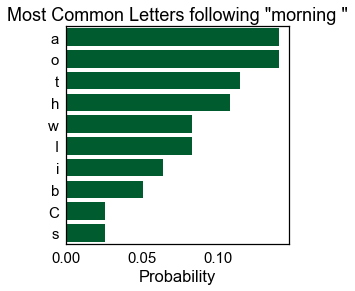

In [100]:
charprobs = probs['morning ']
s_chars = pd.Series(charprobs).sort_values(ascending=False).head(10)
fig = plt.figure(figsize=(4,4), facecolor='w')
p = sns.barplot(y=s_chars.index, x=s_chars, color=(0,.36,.18),
                 saturation=1)
p.set_xlabel('Probability')
p.set_title('Most Common Characters following "morning "');

Recall that our model can handle histories of any order up to `order_max`. Let's test some shorter histories:

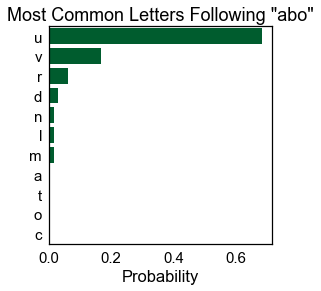

In [99]:
charprobs = probs['abo']
s_chars = pd.Series(charprobs).sort_values(ascending=False).head(20)
fig = plt.figure(figsize=(4,4), facecolor='w')
p = sns.barplot(y=s_chars.index, x=s_chars, color=(0,.36,.18),
                 saturation=1)
p.set_xlabel('Probability')
p.set_title('Most Common Characters Following "abo"');

We can see that "abo" is most often followed by "u" (as in "about"). The next most likely character is "v" (as in "above"), and then "r" (as in "laboratory").

Let's see what letters typically follow the end of a sentence:

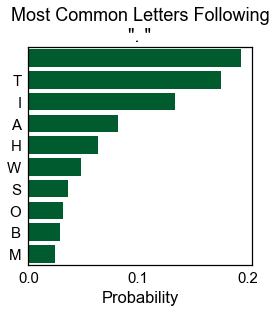

In [103]:
charprobs = probs['. ']
s_chars = pd.Series(charprobs).sort_values(ascending=False).head(10)
fig = plt.figure(figsize=(4,4), facecolor='w')
p = sns.barplot(y=s_chars.index, x=s_chars, color=(0,.36,.18),
                 saturation=1)
p.set_xlabel('Probability')
p.set_title('Most Common Characters Following\n". "');

We can see that the most common character after a sentence is a newline, and that &mdash; as expected &mdash; the next sentence typically starts with a *capital* letter.

Since order-0 character probabilities are included, we can even look at the distribution of characters when there is *no* history (an empty string). This is simply the overall distribution of characters in our corpus.

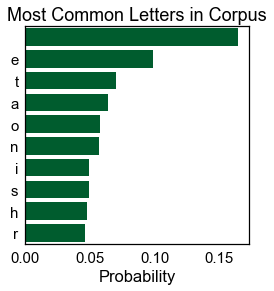

In [102]:
charprobs = probs['']
s_chars = pd.Series(charprobs).sort_values(ascending=False).head(10)
fig = plt.figure(figsize=(4,4), facecolor='w')
p = sns.barplot(y=s_chars.index, x=s_chars, color=(0,.36,.18),
                 saturation=1)
p.set_xlabel('Probability')
p.set_title('Most Common Characters in Corpus');

## Novel Text Generation <a name="6C"></a>

Now we're ready to use our Markov model to generate text using the following procedure:

Suppose we are using an *order-5* Markov model. Starting from some initial length-5 history (e.g. "Bulbo"), we can use our model to look up the distribution of characters that we expect to follow it. We then sample from that distribution, and append the sampled character (e.g. "u") our generated text. We also append the new character to the right of our history, and remove the leftmost character, giving a new length-5 history ("ulbou"). We then repeat this process with our new history, generating another new character and another new history. Thus we can iteratively generate as much text as we like.

Our multi-order Markov model comes in handy if we want to start our text generation without specifying an initial history. We can simply start with the empty string ("") as our initial history, and progressively grow the history's length as we generate new characters, up to the desired Markov order $k$. Since our multi-order character distributions are well defined for these different history lengths, this procedure simply works for us without any fancy tricks.

---

We implement our text generation as two functions:
- `generate_character` samples from the character distribution corresponding to a given history and Markov order, using NumPy's `random.choice()` function.
- `generate_text` repeatedly applies `generate_character` and updates the current history (which is grown and truncated in the process) after generating each character. The resulting string of generated text is then returned.

See the comments below for more implementation details:

In [5]:
def generate_character(probs, order=0, history='' ):
    #Truncate history to length=order
    history = history[-order:]
    
    #Get all characters and their probabilities for the given history
    chars_dict = probs[history]
    chars = list( chars_dict.keys() )
    charprobs = list( chars_dict.values() )
    
    #Return a weighted random sample (1 character).
    return np.random.choice(chars, p=charprobs)

def generate_text(probs, order=0, history='', num_chars=500):
    #List of characters to convert to string at the end
    charlist = []
    
    for i in range(num_chars):
        #Generate the next character, append to charlist
        char = generate_character(probs, order=order, history=history)
        charlist.append(char)
        
        #If order is 0, new history is still empty string. Otherwise, 
        #remove "oldest" character from history, append our new character.
        if order==0:
            history = ''
        else:
            history = history[-order:] + char
    
    #Convert charlist to string and return it
    return ''.join(charlist)

Let's generate some text! We'll start by generating some text from our order-8 Markov model:

In [267]:
generated = generate_text(probs, order=order_max, history='. ', num_chars=1000)
#Replace newlines with spaces to work well with JupyterLab's word wrapping.
display( Markdown( '**Generated text:**\n>' + generated.replace('\n',' ') ) )

**Generated text:**
>It had actually increase in the Pawtuxet Road. Just as I tried more steeper slope, the tree. Then men were flat and gardens. The captain and into two of them. The Pharaoh in the folks out.   “Wheeler?” he had hitherto known goal. All day I had fainted. For a decade of thunder which his rashness had now floated down by his senses reeling now, and salt breeze stirred that he plunged.   Then, in an odd, half-shrouded by the worst things. What he would leap of the lunch room, the gasoline engine of water around me, the sleek, lazy cats of Ulthar when I diffidence in his blood, for his later it delicate a point some vast colleagues, despite the cryptic gesticulate life—albeit a recluse. After Brown is mission; for all the Mediterranean effulgently around my supplied the time I was still and repeated most heartily endorsed as correspondence with outside.   But queerly pigmented sight; their camp on the richly ornate and establish at first, of course fall before me.   And the Daemon of those 

This is far from a *coherent* passage, but recall that we are generating this *one character at a time*, while keeping track of *only the previous 8 characters*. Despite this microscopic procedure, we're able to get very coherent words and even partially coherent sentences. 

For comparison, let's have our multi-order model generate text from Markov models of each order, iterating from `order=0` to `order=8`:

In [210]:
for order in range(0,order_max+1):
    generated = generate_text(probs, order=order, history='. ', num_chars=200)
    pre = '**`order={}`**: '.format(order)
    display( Markdown( pre + generated.replace('\n',' ') ) )

**`order=0`**: Ccohdseuehdtlehwar ewmto mtsi eae ooteoesdnrntymd weet on wan die dmktndhiay rmadsabtubmlif  uogmite sitclotgsiishaibyhpe eiuna hpoyohdaeewaaea  s ctar t wmsmdpn    ttytmte.vrthionee lasueat pyera Tte

**`order=1`**: shave Man. ed yplispr-ecextasery t ous avouroforef he t l  teer Ats isef ccth ppans agnapset oity onnin s. amlerd  areriom Joce thais by hedrery I siongrdene h as us an ousenge’s, enolor t d thitht nd

**`order=2`**:   Dust tout trum, bold. Fostur; agincathe mand themprown of turt th to ants the whapeclowinger’s to ing thidown ne. As I’d But od of Dursill, the dideneis mittlas explis whopere. Mareartle bound lich 

**`order=3`**: North car, I to bed he stor threal our of stated he cosmoken curth scarcommorning were but what the excelies I crawnessuresterness. Thered and, be jagged unknow becauth joureserved, and lose always st

**`order=4`**: Just aeon-likeness second, and always for the was set unlike to the first—larger any paper after unlike javelled a possibilities diplomations of mummy with fears in a sured steeple—the land nause as t

**`order=5`**: Why he solar stream from the laborator to have for writing them repair of the first times, and look, seekingly weller, who was, held come from what their brandy to me talked over than this were my wif

**`order=6`**: Nothing torch had no more saddened hastened down. Answering how oddly enough, but the made and bitter, it’s the priests and from the jagged lions of telepathic man, of the police, the lurking the minu

**`order=7`**: Electric bulb over the world of my now dawns burst intolerably lower the rooms exception was not to take body. Everything instant account. Their small, known of the continued to devour one shuddered, 

**`order=8`**: The smaller continue my search in his car at the place, for as he pored endless avenues of Federal Hill, sketches—varying from the well—seething charge at last the end. I was able to help, and that we

---

Now we can see how our model seems to improve as the Markov order increases.

At order 0, the model simply randomly samples characters according to the overall character distribution. The "words" are incoherent and don't resemble English. Moving up to orders 1 and 2, we start to see words that roughly resemble English, as well as sentences that start with capital letters and end with periods. With orders 3 through 5, we see many coherent words and sentences that do look like English, though meandering and incoherent. By orders 6 through 8, we see almost no gibberish words, and slightly more coherent sentences.

## Optimal Markov Order via k-Fold Cross-Validation <a name="6D"></a>

The above results might suggest making our Markov order as large as possible to get the best results. If we allowed the Markov order of our model to continue to grow very large, we *would* eventually see *perfectly coherent English*, but the model will have *overfit* to our training corpus. At these high orders, a given, very-long history will have been seen *only a few times* (or even a *single* time). The generator will therefore deterministically produce *verbatim passages* from Lovecraft's texts. Clearly, this is not the goal of our language model. Instead, we want an ideal *tradeoff* between coherence and variability.

We'll combat this overfitting just as we do with many other machine learning models &mdash; by using *cross-validation*. For each order, we'll determine the performance of our model by training it on a subset of our data, and testing it on a held-out set of data. Testing will consist of scanning through the held-out text, and seeing what character follows each history of characters. For each of these history/character pairs, we'll calculate the probability that our model assigns to the character, given the history (directly from its character probability dictionary). We'll then simply average these probabilities over all of the history/character pairs in the held-out text. Since we're performing *cross*-validation, we'll do this *repeatedly* for multiple combinations of training and test texts (more details on this below).

Our scoring gives us the *average probability* that our model would generate the "correct" character from our held-out text, given the history that preceded it. A more common practice would be to multiply these probabilities (or add up the log probabilities) to obtain a *total likelihood* (or *log*-likelihood). Since this would lead to a likelihood of 0 (or negative infinite log-likelihood) when the model assigns a zero probability to even *one* of the history/character pairs, I found that simply averaging the probabilities gives a more useful score.

---

Normally, we'd use an optimized implementation of cross-validation like the one found in scikit-learn. Since we built our model from scratch, let's instead build our cross-validation from scratch as well. Our implementation consists of three functions:
- `average_prob` scans across a string of validation text, calculates conditional character probabilities from each history/character pair (based on a given model), and returns the average of these probabilities. If it runs into a history/character pair that wasn't seen in the training text, that pair doesn't contribute to the average probability.
- `scoreplot` displays our per-order scores as a simple line chart.
- `markov_multi_cv` performs k-fold cross-validation ("k" here is not the same as the Markov order). For each fold, it splits the corpus into training and test sets (each contiguous, see below). It then trains our multi-order Markov model on the training set, and tests its performance (using `average_prob`) on the validation set *for each order* up to `order_max`. This gives us a per-order *list* of scores that are then aggregated across folds. Note that &mdash; thanks to our *multi-order* Markov model &mdash; we don't need to train each order-k model separately for every fold. Finally, our cross-validated scores are shown using the previous `scoreplot` function.

Note: In *typical* k-fold cross-validation, we can (and usually *should*) shuffle our datapoints before splitting them into training and test sets. If we did this with our corpus, however, we would destroy all of its structure (since it is *not* [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)). We instead cut our corpus into *contiguous* chunks during each fold.

See the comments and code below for more details.

In [9]:
def average_prob(model, data, order):
    
    #Total number of history/char pairs
    num_pairs = len(data) - order
    
    prob_average = 0
    for i in range(num_pairs):
        history = data[i:i+order]
        char = data[i+order]
        
        #Catch KeyError when the current history/char pair isn't found in the
        #model's dictionary (i.e. the pair didn't appear in the training text)
        try:
            #Add current character probability to total
            prob = model[history][char]
            prob_average += prob
        except KeyError:
            #"Add zero" to total
            pass
    
    #Normalize average probability and return it.
    prob_average = prob_average/num_pairs
    return prob_average

def scoreplot(scores_train, scores_val, title='', xlabel='', ylabel=''):
    #Create list of indices for plotting
    xs = list( range( len(scores_train) ) )
    
    fig = plt.figure(figsize=(6,6), facecolor='w')
    
    #Create overlapping line/point plots for each list of scores
    plot_kwargs = dict(linestyle='-', marker='o')
    plt.plot(xs, scores_val, color=(0,0,0), ms=15, lw=6, **plot_kwargs )
    plt.plot(xs, scores_train, color=(1,0,0), ms=8, lw=3, **plot_kwargs )
    
    #Add legend, title, and labels
    plt.legend(['Validation', 'Training'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return

def markov_multi_cv(data, order_max, folds=10):
    
    #Size of validation set
    val_size = int( len(data)/folds )
    
    #Average character probabilities for each Markov order
    average_probs_train = np.zeros(order_max+1)
    average_probs_val = np.zeros(order_max+1)
    
    #Train once per fold, evaluate all orders within fold.
    for i in range(folds):
        
        #Construct train and validation set.
        #Concatenating the two training chunks like this will break text 
        #structure at boundary, but the effect is insignificant for even a 
        #moderately sized corpus.
        text_train = data[:i*val_size] + data[(i+1)*val_size:]
        text_val = data[ i*val_size : (i+1)*val_size ]
        
        #Train multi-order Markov model.
        model = char_markov_multi(text_train, order_max)
        
        #Add character probabilities for this fold to average_probs,
        #pre-normalized by the number of folds.
        for order in range(order_max+1):
            average_probs_train[order] += average_prob(
                                                model, text_train, order )/folds
            average_probs_val[order] += average_prob(
                                                model, text_val, order )/folds
        
        #Print progress. Overwrite line each iteration.
        print( '\rFold {}/{} complete.'.format(i+1,folds), end='' )
    
    #Plot scores
    title = 'Markov Model Cross-Validation Scores'
    xlabel = 'Markov Order'
    ylabel = 'Average Likelihood'
    scoreplot(average_probs_train, average_probs_val, title=title, 
              xlabel=xlabel, ylabel=ylabel)

    return

Let's run our cross-validation on our merged corpus!

Fold 10/10 complete.

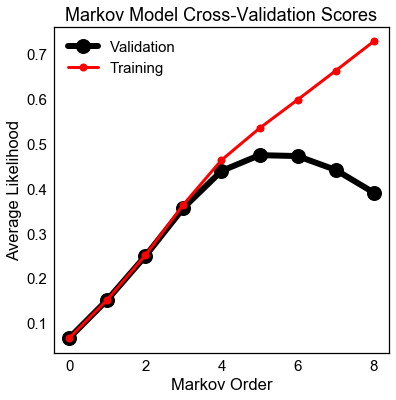

In [10]:
markov_multi_cv(load_texts_merged(filenames), order_max=order_max, folds=10)

We can see that our scores on the training text increase monotonically as the Markov order increases, but our validation scores peak at a Markov order of 5. Thus our generalization performance is maximized at order 5, with larger orders overfitting to the training text. The order-8 model, for example, has worse generalization performance than even the order-4 model.

The validation score for our order-5 model is approximately $\frac{1}{2}$. This indicates that the order-5 model would have generated the correct character around half the time (given a specific history in the validation text). This isn't bad given the number of possible characters, and the fact that the model is being tested on text that it wasn't trained on. For comparison, a uniformly *random* generator would give a score of $\frac{1}{131} \approx 0.008$, since there are $131$ unique characters in our corpus.

In contrast to the validation score, the *training* score is around $\frac{3}{4}$ at order 8, and would steadily converge to $1$ if we allowed the order to continue to grow.

The order-6 model gives *nearly* the same average likelihood as the order-5 model, so it might be a good candidate as well, especially since these scores come from training on only 90% of the dataset (per fold). Nonetheless, we'll trust our cross-validated scores and conclude that the **order-5** Markov model is optimal for our corpus. Let's again generate a passage, now with this model:

In [270]:
generated = generate_text(probs, order=5, history='. ', num_chars=1000)
#Replace newlines with spaces to work well with JupyterLab's word wrapping.
display( Markdown( '**Generated text:**\n>' + generated.replace('\n',' ') ) )

**Generated text:**
>It would be some obscure vaguely great from its carven the night, their tribe, saving “Custody of great Warren:   “The Town Schweinkopf’s words; and Carter of the reef we had under than this Seaton is pleasure the begun to intact, thick a golden pain in the more and other modern miss whereby young monotonous pulse to be prepared face seething dizzy on and ‘alive, no far belonger the Hill with Akeley’s inner of primal, alien naturally recent maddening, truly audible work, N.Y., was they tools of Oriab so many light again a loudly charm him—embracing very nightmare cleverlying a veritage had got the immunicated in Salem to walking in unwarrant to separate had sense course blights all to the sunset city of standing a potently his red graceful and again. Recurrent flapping from the spell the whirling bands in the cave of time Lake his ruled to means strange. At five of earth to sharp-point of the kind on that what he sea and was so steeds. I have him well, unbolted my first its while draug

Again, the text meanders (and does so more than our order-8 model), but this model gives the best tradeoff between coherence and novelty (at least according to our cross-validated scores). It thus sacrifices coherence to avoid generating entire verbatim passages from our corpus. The more advanced smoothing/interpolation methods and deep learning approaches discussed above will certainly give much better scores, albeit with much greater model complexity and/or training time.

## Weird Non-Words <a name="6E"></a>

Arguably, the most entertaining part of character-based generative language models is the bizarre non-words that it pieces together. Let's close this section by explicitly analyzing these weird non-words.

We'll do this by using our Markov model to generate a large amount of text, calculating word counts from this generated text, and inspecting the words that are not present in the original corpus. We'll do this for a couple of different Markov orders.

Note: We could also calculate *probability ratios* (as we did previously) to compare our generated text to Lovecraft's writings. This would highlight words that *are present* in Lovecraft's writings, but that our model expects *more* of. While this is certainly interesting, we would like to focus on words that aren't found in the original corpus.

---

First, let's define a function &mdash; `counts_from_string` &mdash; that generates a word count dataframe from a given string (rather than a file). This function makes use of our `tokenize_text` and `tokens_to_counts` functions that we defined above.

In [22]:
def counts_from_string(string, lowercase=True):
    tokens = tokenize_text(string)
    df_counts = tokens_to_counts(tokens, lowercase=lowercase)
    return df_counts

We'd like to generate a large amount of text so we can get good statistics. Let's go ahead and generate as much text as is found in our *entire corpus*. To this end, let's calculate and store the total number of letters in Lovecraft's complete works:

In [23]:
filenames = glob.glob('./data/stories/*.txt')
nletters_hpl = len( load_texts_merged(filenames) )
print( 'Size of Lovecraft\'s writings: {} characters.'.format(nletters_hpl) )

Size of Lovecraft's Writings: 4031122 characters.


### Markov Order = 5

Now we're ready to generate our text. First, let's try our order-5 model, which gave the best cross-validated average likelihood.

In [274]:
generated_text_5 = generate_text(probs, order=5, history='. ', 
                                 num_chars=nletters_hpl)

Now let's build our generated word counts and filter out the words that aren't found in our Lovecraft corpus.

In [276]:
df_weird_5 = counts_from_string(generated_text_5)
df_weird_5 = df_weird_5[ ~df_weird_5.Word.isin( df_counts_hpl.Word ) ]

We can visualize the top non-words as a bar plot:

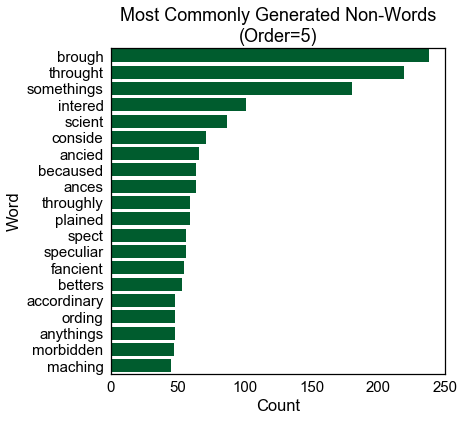

In [277]:
fig = plt.figure(figsize=(6,6), facecolor='w')
p = sns.barplot( x='Count', y='Word', data=df_weird_5.head(20), 
                 color=(0,.36,.18), saturation=1 )
p.set_xlabel('Count')
p.set_title('Most Commonly Generated Non-Words\n(Order=5)');

We can see that the model likes to generate pluralized versions of words that are never plural, and [portmanteaus](https://en.wikipedia.org/wiki/Portmanteau) of multiple words. Take "brough" for example. This word appears nowhere in Lovecraft's writings, but the words "brought" and "rough" do. Our order-5 model therefore sees "h" as being a valid and probable character to follow the length-5 history "broug," and then considers it valid and probable to end the word after having seen the length-5 history "rough".

Similarly, "throught" could perhaps be seen as a portmanteau of "through" and "thought," "intered" could be a portmanteau of "interested" and "entered," and "scient" a portmanteau of "science" and "prescient." Even the pluralized words such as "somethings" can be seen as portmanteaus ("something" + "things" = "somethings"). Again, these are all simply interpretations of artifacts due to the model's short memory.

Overall, the non-words generated by our model look like words that a non-fluent English speaker might make up: They all seem like plausibly-valid words, based solely on the typical patterns seen in *valid* English words. In fact, I could imagine any of these words becoming valid English words in the future:

*"Spect those speculiar, fancient somethings along the morbidden ances!"*

---

Some of the *weirdest* non-words are those that were only generated *once*. Let's have a look at some:

In [279]:
weird_words = df_weird_5.Word.tail(50).values
display( Markdown( '**' + '**  -  **'.join(weird_words) + '**' ) )

**enterstition**  -  **retrospectors**  -  **filiation**  -  **deterrestrain**  -  **returnings**  -  **synthes**  -  **droningly**  -  **senaths**  -  **colonishings**  -  **examinationship**  -  **charginas**  -  **availabled**  -  **throughs**  -  **boardingly**  -  **mnemonious**  -  **silential**  -  **rections**  -  **printent**  -  **progressor**  -  **cafetering**

We can also simply view a random sample of the non-words to see a nice variety:

In [281]:
weird_words = df_weird_5.Word.sample(100).values
display( Markdown( '**' + '**  -  **'.join(weird_words) + '**' ) )

**circularity**  -  **proporticos**  -  **bafflements**  -  **consistered**  -  **acquaintly**  -  **atavistic**  -  **leaguest**  -  **fragmenteresting**  -  **standg**  -  **provertook**  -  **accidentificial**  -  **speard**  -  **sessing**  -  **alliantly**  -  **tellingly**  -  **suspend**  -  **dwellingness**  -  **credulously**  -  **stanists**  -  **cemeteriors**  -  **woodchuckled**  -  **indignity**  -  **freudianus**  -  **intelled**  -  **easterfields**  -  **detestablished**  -  **scornfully**  -  **windowlessness**  -  **nicholars**  -  **calien**  -  **premony**  -  **transferences**  -  **wreckages**  -  **degenerally**  -  **remoniac**  -  **reveller**  -  **overpool**  -  **accountless**  -  **volitician**  -  **isoscelestial**  -  **mobiles**  -  **pourings**  -  **accentral**  -  **necessible**  -  **frontinual**  -  **harasse**  -  **heedle**  -  **recaller**  -  **cottered**  -  **luxurian**  -  **grotests**  -  **exquisitors**  -  **implants**  -  **untrance**  -  **interbreed**  -  **contracteristic**  -  **ankled**  -  **putrescended**  -  **anathan**  -  **counterested**  -  **gratefulness**  -  **bowering**  -  **monstrosition**  -  **identific**  -  **treasuredly**  -  **transportal**  -  **circumferent**  -  **unexpection**  -  **afterthough**  -  **phosphores**  -  **compensable**  -  **hospitalising**  -  **interpreternatural**  -  **interror**  -  **suitablet**  -  **blunderscoriac**  -  **standings**  -  **waterson**  -  **uncoverse**  -  **intendence**  -  **uncontrivanced**  -  **requestiness**  -  **decreants**  -  **christchurchyard**  -  **pleasurely**  -  **restores**  -  **encrustached**  -  **metabolic**  -  **lastic**  -  **incapaciousness**  -  **exacting**  -  **judgingly**  -  **stricked**  -  **perfective**  -  **graduations**  -  **cravine**  -  **anothoas**  -  **sprinkly**  -  **unaccountenance**  -  **unreachers**

"Monstrosition." "Isoscelestial." *Nice*. 

---

Let's try a different Markov order.

### Markov Order = 2

In [24]:
generated_text_2 = generate_text(probs, order=2, history='. ', 
                                 num_chars=nletters_hpl)
df_weird_2 = counts_from_string(generated_text_2)
df_weird_2 = df_weird_2[ ~df_weird_2.Word.isin( df_counts_hpl.Word ) ]

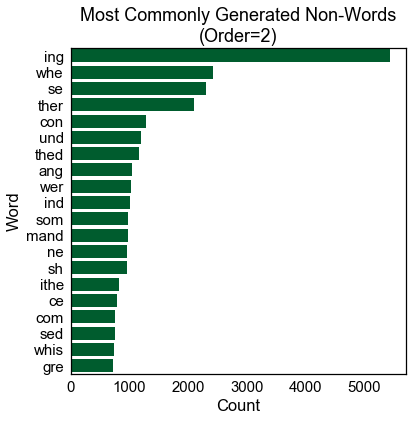

In [25]:
fig = plt.figure(figsize=(6,6), facecolor='w')
p = sns.barplot( x='Count', y='Word', data=df_weird_2.head(20), 
                 color=(0,.36,.18), saturation=1 )
p.set_xlabel('Count')
p.set_title('Most Commonly Generated Non-Words\n(Order=2)');

Here we see another interesting phenomenon. The most common non-words generated by a Markov model seem to have lengths that are close to the Markov order itself. Most of the words above are the *heads* or *tails* of valid English words, which is sufficient justification for the order-2 model to end the words abruptly.

For example, take the top word &mdash; "ing." Our order-2 model likely generates it frequently because "in" is an incredibly common way to start a word, and "ng" is an incredibly common way to *end* a word. A higher-order Markov model would see the entire string "ing" (preceded by whitespace) and know that it would *never* be followed by whitespace. Such a model might instead continue to generate a word such as "ingot" or "ingest" (or perhaps some portmanteau such as "ingestation").

---

Finally, let's look at a random sample of weird words generated by our order-2 model.

In [35]:
weird_words = df_weird_2.Word.sample(100).values
display( Markdown( '**' + '**  -  **'.join(weird_words) + '**' ) )

**tumatiod**  -  **ressane**  -  **tornimispium**  -  **anourtereat**  -  **skiloold**  -  **wribefte**  -  **straxed**  -  **fromfook**  -  **whoncas**  -  **livintrat**  -  **nistiout**  -  **groperinste**  -  **whoss**  -  **abonarcatimend**  -  **peciet**  -  **deirs**  -  **twasing**  -  **hirtas**  -  **dreguener**  -  **surstry**  -  **riefor**  -  **orriounre**  -  **clogramorriping**  -  **tooking**  -  **wholithe**  -  **thning**  -  **wookent**  -  **hingload**  -  **skult**  -  **flawn**  -  **secall**  -  **thue**  -  **wherter**  -  **noccof**  -  **curefuld**  -  **voutly**  -  **gammes**  -  **overther**  -  **taiced**  -  **grombes**  -  **cyclur**  -  **witind**  -  **hicton**  -  **adues**  -  **wellies**  -  **kettan**  -  **eanat**  -  **yetteded**  -  **asent**  -  **heades**  -  **resed**  -  **tobit**  -  **uneallyliverhaddestrome**  -  **tranizehis**  -  **debodough**  -  **wrat**  -  **scamer**  -  **andeed**  -  **inglams**  -  **beleasenter**  -  **catypt**  -  **thoseart**  -  **gainterreete**  -  **alkin**  -  **raith**  -  **spectele**  -  **clanganare**  -  **thiceetainges**  -  **nifely**  -  **thavertyarrion**  -  **tompican**  -  **therhatatle**  -  **graccur**  -  **gilly**  -  **sersts**  -  **proscess**  -  **whisiblet**  -  **rigic**  -  **thmid**  -  **lencead**  -  **nortaile**  -  **morytheirs**  -  **therably**  -  **ardideregetery**  -  **slen**  -  **carione**  -  **faceritenst**  -  **pulhumorethe**  -  **seening**  -  **warednt**  -  **winget**  -  **scruslatep**  -  **thenterevent**  -  **usturamaildish**  -  **alloared**  -  **bubt**  -  **bicomed**  -  **gnoncosed**  -  **thang**  -  **thiverest**

---

"I merd Protilly’s horld stain.. Hinly my goomights of trour!"

"Sorbeemboverhancessamentlikepeciond."

...



# End

**I hope you've enjoyed exploring Lovecraft's writings as much as I have! If you'd like to see more, please check out [my GitHub profile](https://github.com/nxbrnt).**